## Figure 5 Code to Produce Figures

This figure will focus on the presentation of Motif Analysis.

In [ ]:
# importing packages
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
import json
from tqdm import tqdm
from scipy import stats
import seaborn as sns
import networkx as nx
plt.rcParams.update({'font.size': 20})
plt.rcParams["figure.figsize"] = (10,10)
sns.set_theme(style="whitegrid")
results_folder = "pyr_only_rectangular_results"
random.seed(747)

# Import Stefan's Library for Data Management of V1DD
from lsmm_data import LSMMData

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [3]:
def invert_dict(original_dict):
    inverted_dict = {}
    for key, items in original_dict.items():
        for item in items:
            if item not in inverted_dict:
                inverted_dict[item] = [key]
            else:
                inverted_dict[item].append(key)
    return inverted_dict

### Load in Data from LSMMData Wrangler

In [4]:
# Import Stefan's Library for Data Management of V1DD
from lsmm_data import LSMMData

with open('pyr_rectangular.json') as f:
    loaded_json = json.load(f)
v1dd_data_all_to_all = LSMMData.LSMMData(loaded_json)
tables = v1dd_data_all_to_all.data
params = v1dd_data_all_to_all.params
dirs = v1dd_data_all_to_all.dirs
mappings = v1dd_data_all_to_all.mappings

Filtering to pyramidal cells only
459


/Users/jawagnercarena/opt/anaconda3/envs/assembly/lib/python3.10/site-packages/lsmm_data/LSMMData.py:391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['structural']['post_cell']['connectome_index'] = data['structural']['post_cell'].index
/Users/jawagnercarena/opt/anaconda3/envs/assembly/lib/python3.10/site-packages/lsmm_data/LSMMData.py:417: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['structural']['post_cell']['pt_position'] = [[data['structural']['post_cell'].iloc[i]['pt_position_x'],data['st

Generating Connectome...


100%|██████████| 44293/44293 [00:08<00:00, 5197.08it/s]


Generating Connectome...


100%|██████████| 44293/44293 [00:10<00:00, 4356.13it/s]


In [5]:
tables['structural'].keys()

dict_keys(['post_cell', 'pre_cell', 'synapse', 'synapse_count_connectome', 'binary_connectome', 'summed_size_connectome', 'averaged_size_connectome'])

In [6]:
binary_connectome = tables['structural']['binary_connectome']
synapse_count_connectome = tables['structural']['synapse_count_connectome']
summed_size_connectome = tables['structural']['summed_size_connectome']
average_size_connectome = tables['structural']['averaged_size_connectome']

In [7]:
# Need to make a new graph to define the connectivity between pre and post-synpatic cell
pyr_graph = nx.DiGraph()
rows, cols = binary_connectome.shape
for i in range(rows):
    for j in range(cols):
        if binary_connectome[i, j] != 0:  # 0 means no edge
            pyr_graph.add_edge(f'pre_{i}', f'post_{j}', weight=binary_connectome[i, j])

In [8]:
# Produce Motif Results with dotmotif
from dotmotif import Motif,GrandIsoExecutor
executor = GrandIsoExecutor(graph=pyr_graph)
chain_type = Motif("""
                A -> B
              """)
synaptic_connections = executor.find(chain_type)

In [9]:
np.zeros_like(list(synaptic_connections[0].values()))

array(['', ''], dtype='<U6')

In [10]:
# Enumerate the DotMotif Result
two_chain_results_array = np.array([list(synapse.values()) for synapse in tqdm(synaptic_connections)])
removed_pre_post_strings = np.zeros_like(two_chain_results_array)
for i, synapse in enumerate(synaptic_connections):
    for j, cell in enumerate(synapse.values()):
        removed_pre_post_strings[i, j] = int(cell.split('_')[1])

two_chain_results_array = np.array(removed_pre_post_strings).astype(int)

100%|██████████| 39392/39392 [00:00<00:00, 526758.52it/s]


In [11]:
### Produce a dictionary for Assemblies by Coregistered
assemblies_by_coregistered = invert_dict(mappings['assemblies_by_connectome_index'])
post_assemblies_by_coregistered = invert_dict(mappings['assemblies_by_post_connectome_index'])
# Produce Indexes for Assembly Cells and Non Assembly Cells
assembly_connectome_indexes = []
no_assembly_connectome_indexes = []
for key, val in mappings['assemblies_by_connectome_index'].items():
    if val == ['No A']:
        no_assembly_connectome_indexes.append(key)
    else:
        assembly_connectome_indexes.append(key)

In [12]:
# Produce a list of ids of around 50 Non-Reg Pyramidal Cells
pyr_cell_types = ['2P', '3P', '4P', '5P', '5P-ET', '5P-NP', '6P']
all_pyr_indices = np.where(np.isin(tables['structural']['pre_cell']['cell_type_v2'], pyr_cell_types))[0]

registered_ids = set(assembly_connectome_indexes) | set(no_assembly_connectome_indexes)
all_non_registered_ids = [i for i in all_pyr_indices if i not in registered_ids]
random.seed(747) # set seed
non_registered_ids = random.sample(all_non_registered_ids, k= 50)
#non_registered_ids

In [13]:
mappings.keys()

dict_keys(['functional_indexes_by_assembly', 'assemblies_by_functional_index', 'pt_root_id_to_connectome_index', 'connectome_index_to_root_id', 'pt_root_id_to_post_connectome_index', 'post_connectome_index_to_root_id', 'roi_id_to_pt_root_id', 'pt_root_id_to_roi_id', 'roi_id_to_functional_index', 'functional_index_to_roi_id', 'assemblies_by_roi_id', 'assemblies_by_pt_root_id', 'assemblies_by_connectome_index', 'assemblies_by_post_connectome_index', 'connectome_indexes_by_assembly', 'post_connectome_indexes_by_assembly', 'pt_root_ids_by_assembly', 'roi_ids_by_assembly'])

In [14]:
## Initialize Helpful Tracking Arrays
coregistered_cells = np.array(list(mappings['assemblies_by_connectome_index'].keys()))
coregistered_post_cells = np.array(list(mappings['assemblies_by_post_connectome_index'].keys()))
no_assembly_cells = np.array(list(mappings['connectome_indexes_by_assembly']['No A']))
no_assembly_post_cells = np.array(list(mappings['post_connectome_indexes_by_assembly']['No A']))
all_assembly_indexes = np.array(list(set(coregistered_cells) - set(no_assembly_cells)))
all_assembly_post_indexes = np.array(list(set(coregistered_post_cells) - set(no_assembly_post_cells)))

In [15]:
np.sort(all_assembly_indexes)

array([ 44,  54,  55,  73,  78,  94,  98,  99, 102, 105, 107, 117, 118,
       119, 129, 132, 138, 140, 144, 156, 159, 160, 161, 170, 171, 173,
       181, 196, 198, 203, 204, 206, 211, 213, 217, 224, 232, 247, 249,
       251, 256, 259, 276])

In [16]:
np.sort(all_assembly_post_indexes)

array([ 632,  645,  691,  708,  717,  725,  761,  771,  862,  908,  932,
       1055, 1073, 1078, 1129, 1144, 1170, 1184, 1194, 1264, 1334, 1339,
       1343, 1369, 1393, 1526, 1547, 1556, 1585, 1623, 1635, 1669, 1732,
       1742, 1746, 1773, 1789, 1791, 1809, 1813, 1816, 1874, 1878, 1886,
       1905, 1927, 1970, 2031, 2158, 2204, 2213, 2221, 2255, 2258, 2263,
       2290, 2317, 2356, 2384, 2408, 2462, 2466, 2624, 2651, 2735, 2761,
       2971, 3004, 3107, 3120, 3146, 3205, 3233, 3267, 3391, 3470, 3695,
       3718, 3731, 3768, 3771])

### Validating PSD Intra vs Inter Assembly

In [17]:
def inter_vs_intra_connections_plot(input_connections_dict: dict,
                                        directionality: str,
                                        binary_counts: bool,
                                        syn_counts: bool, 
                                        summed_psd : bool,
                                        average_psd: bool,
                                        show_p_vals: bool,
                                        consider_zero_connections = True):
    
    if binary_counts and syn_counts:
        raise ValueError("Must either be working with binary or synaptic count connectome.")
    if summed_psd and average_psd:
        raise ValueError("Must either be working with summed or average PSD values.")
    if (binary_counts or syn_counts) and (summed_psd or average_psd):
        raise ValueError("Must either be working with PSD or connectivity.")
    
    # Based on the connectome flags, save it in the right folder, set the correct y_label and plot title
    if binary_counts:
        connectome_desc = "Binary"
        folder = "binary_connectome"
        suffix = "Binary Connectivity"
        y_lab = "Normalized Binary Connections"
    elif summed_psd:
        connectome_desc = "Summed_PSD"
        folder = "summed_size_connectome"
        suffix = "Post Synaptic Strength"
        y_lab = "Normalized Summed Synaptic Strength (PSD in nm$^3$)"
    elif average_psd: 
        connectome_desc = "Average_PSD"
        folder = "average_size_connectome"
        suffix = "Post Synaptic Strength"
        y_lab = "Normalized Average Synaptic Strength (PSD in nm$^3$)"
    elif syn_counts:
        connectome_desc = "SynCounts"
        folder = "synapse_count_connectome"
        suffix = "First-Order Connectivity"
        y_lab = "Normalized Synaptic Counts"
    else:
        raise ValueError("Must specify which connectome is being used.")

    connections_dict = {}
    for key in input_connections_dict.keys():
        connections_dict[key] = np.array(input_connections_dict[key])

    suffix = f"Intragroup vs Intergroup {directionality} " + suffix
    connectome_desc = "Intra_vs_Inter_" + connectome_desc

    if not consider_zero_connections:
        suffix = suffix + " (Non-Zero)"
        connectome_desc = connectome_desc + "_Non_Zero_"

    # Establish Statistical Test
    all_arr = [connections_dict['Inter-A'], connections_dict['Intra-A']]
    x_ticks = ["Inter-A", 'Intra-A']
    arr_medians = [np.median(np.array(connections_dict['Inter-A'])), np.median(np.array(connections_dict['Intra-A']))]
    val = stats.ranksums(connections_dict['Intra-A'], connections_dict['Inter-A'], 'greater').pvalue
    p_values = [np.nan, '{:.3g}'.format(val, 5)]

    # Define Colors based on Signfiicance
    colors = ['lightgrey' if float(p_val) >= 0.05 or np.isnan(float(p_val)) else (.4, .6, .8, .5) for p_val in p_values]

    # Create a figure with specific size and Plot Results
    _, ax = plt.subplots(figsize=(12, 8))  # Width = 12 inches, Height = 6 inches
    sns.set_theme(style="whitegrid")
    sns.boxplot(data=all_arr,
                    notch= False, showcaps=True,
                    flierprops={"marker": "x"},
                    medianprops={"color": "coral"},
                    palette= colors,
                    ax = ax
                )
    ax.set_xticklabels(x_ticks, size = 14)
    ax.set_title(f'Assembly Cell Involvement: {suffix}', size = 16)
    ax.set_ylabel(y_lab, size = 14)
    plt.xticks(rotation=45)

    # Create legend
    custom_legend = [plt.Line2D([0], [0], color='lightgrey', lw=7, label='No Significant Difference from Inter A'),
                    plt.Line2D([0], [0], color=(.4, .6, .8, .5), lw=7, label='Significant Difference from Inter A')]
    plt.legend(handles=custom_legend, loc='best')

    # If you want to print P-Values, place them on the plot above the median

    if show_p_vals:
        medians = np.array(arr_medians)
        vertical_offset = medians * 0.005 # offset from median for display
            
        for xtick in ax.get_xticks():
            if xtick != 0:
                ax.text(xtick, medians[xtick] + vertical_offset[xtick], p_values[xtick],  # type: ignore
                        horizontalalignment='center', fontsize=10, color='black', weight='semibold')

    fig_title = f"Rectangular_Intra_vs_Inter_{directionality}_{connectome_desc}_Assemblies_Boxplot.png"
    
    plt.savefig(f'{results_folder}/{folder}/{fig_title}', dpi = 1200)
    plt.tight_layout()
    plt.show()

In [18]:
zero_connection_count = 0
connection_count = 0
by_precell_outbound_binary_intra_assembly_first_order = []
by_precell_outbound_binary_inter_assembly_first_order = []
by_precell_outbound_syn_count_intra_assembly_first_order = []
non_zero_by_precell_outbound_syn_count_intra_assembly_first_order = []
by_precell_outbound_syn_count_inter_assembly_first_order = []
non_zero_by_precell_outbound_syn_count_inter_assembly_first_order = []
by_precell_outbound_summed_psd_intra_assembly_first_order = []
non_zero_by_precell_outbound_summed_psd_intra_assembly_first_order = []
by_precell_outbound_summed_psd_inter_assembly_first_order = []
non_zero_by_precell_outbound_summed_psd_inter_assembly_first_order = []
by_precell_outbound_average_psd_intra_assembly_first_order = []
non_zero_by_precell_outbound_average_psd_intra_assembly_first_order = []
by_precell_outbound_average_psd_inter_assembly_first_order = []
non_zero_by_precell_outbound_average_psd_inter_assembly_first_order = []

assemblies_by_coregistered_sans_no_a = {k: v for k, v in assemblies_by_coregistered.items() if k != 'No A'}
post_assemblies_by_coregistered_sans_no_a = {k: v for k, v in post_assemblies_by_coregistered.items() if k != 'No A'}

# Intra-Group
for pre_assembly, pre_cells in assemblies_by_coregistered_sans_no_a.items():
    actual_assembly_connections = 0
    post_cells = post_assemblies_by_coregistered_sans_no_a[pre_assembly]
    #initialize normalization constants
    all_possible_intra_connections = len(pre_cells) * (len(post_cells) - 1) #n*n-1
    possible_outbound_intra_group = (len(post_cells) - 1) # n-1
    #print(possible_outbound_intra_group)
    
    for pre_cell in pre_cells:
        pre_cell_connections = 0
        pre_cell_syn_count = 0
        pre_cell_summed_psd = 0
        pre_cell_average_psd = 0
        pre_cell_zeros = 0

        for post_cell in post_cells:
            if np.any(np.logical_and(two_chain_results_array[:, 0] == pre_cell, two_chain_results_array[:, -1] == post_cell)):
                # Pull connectivity from each connectome
                indv_cell_connection = 1 # binary connectome
                indv_syn_count = synapse_count_connectome[pre_cell, post_cell]
                indv_summed_psd_size = summed_size_connectome[pre_cell, post_cell]
                indv_average_psd_size = average_size_connectome[pre_cell, post_cell]
                # aggregate
                pre_cell_connections += indv_cell_connection
                pre_cell_syn_count += indv_syn_count
                pre_cell_summed_psd += indv_summed_psd_size
                pre_cell_average_psd += indv_average_psd_size
                actual_assembly_connections += 1
                connection_count += 1        
            else:
                zero_connection_count += 1
                pre_cell_zeros += 1
        if (pre_cell_zeros > 0 and pre_cell_connections > 0):
            non_zero_by_precell_outbound_syn_count_intra_assembly_first_order.append(pre_cell_syn_count / pre_cell_connections)
            non_zero_by_precell_outbound_summed_psd_intra_assembly_first_order.append(pre_cell_summed_psd / pre_cell_connections)
            non_zero_by_precell_outbound_average_psd_intra_assembly_first_order.append(pre_cell_average_psd / pre_cell_connections)
        if (possible_outbound_intra_group > 0):
            by_precell_outbound_binary_intra_assembly_first_order.append(pre_cell_connections / possible_outbound_intra_group)
            by_precell_outbound_syn_count_intra_assembly_first_order.append(pre_cell_syn_count / possible_outbound_intra_group)
            by_precell_outbound_summed_psd_intra_assembly_first_order.append(pre_cell_summed_psd / possible_outbound_intra_group)
            by_precell_outbound_average_psd_intra_assembly_first_order.append(pre_cell_average_psd / possible_outbound_intra_group) 

print(f"Pooled Intra-Assembly Connections: {connection_count} out of {zero_connection_count + connection_count} possible")

# Inter-Group
zero_connection_count = 0
connection_count = 0
for pre_assembly, pre_cells in assemblies_by_coregistered_sans_no_a.items():
    actual_assembly_connections = 0
    for post_assembly in post_assemblies_by_coregistered_sans_no_a.keys():
        if pre_assembly != post_assembly:

            ### Initialize normalization constants, long process that will be refactored later
            post_cells_in_pre_indexing = []
            for post_cell_index in post_assemblies_by_coregistered_sans_no_a[post_assembly]:
                post_root = mappings['post_connectome_index_to_root_id'][post_cell_index]
                try:
                    post_cells_in_pre_indexing.append(mappings['pt_root_id_to_connectome_index'][post_root])
                except(KeyError):
                    pass
            overlap_to_remove_in_pre = list(set(assemblies_by_coregistered_sans_no_a[pre_assembly]) & set(post_cells_in_pre_indexing))
            overlap_root_ids_to_remove = [mappings['connectome_index_to_root_id'][c] for c in overlap_to_remove_in_pre]
            overlap_indexes_to_remove_in_post = [mappings['pt_root_id_to_post_connectome_index'][r] for r in overlap_root_ids_to_remove]
            unique_post_indexes_in_post = set(post_assemblies_by_coregistered_sans_no_a[post_assembly]) - set(overlap_indexes_to_remove_in_post)
            unique_post_indexes = unique_post_indexes_in_post
            possible_connections_inter_group = len(assemblies_by_coregistered_sans_no_a[pre_assembly]) * (len(unique_post_indexes)) #n_1*n_2
            possible_outbound_connections_inter_group = len(unique_post_indexes) # n_2
            # print(pre_assembly, post_assembly, possible_outbound_connections_inter_group)


            for pre_cell in pre_cells:
                pre_cell_connections = 0
                pre_cell_syn_count = 0
                pre_cell_summed_psd = 0
                pre_cell_average_psd = 0
                pre_cell_zeros = 0

                for post_cell in unique_post_indexes:
                    if np.any(np.logical_and(two_chain_results_array[:, 0] == pre_cell, two_chain_results_array[:, -1] == post_cell)):
                        # Pull connectivity from each connectome
                        indv_cell_connection = 1 # binary connectome
                        indv_syn_count = synapse_count_connectome[pre_cell, post_cell]
                        indv_summed_psd_size = summed_size_connectome[pre_cell, post_cell]
                        indv_average_psd_size = average_size_connectome[pre_cell, post_cell]
                        # aggregate
                        pre_cell_connections += indv_cell_connection
                        pre_cell_syn_count += indv_syn_count
                        pre_cell_summed_psd += indv_summed_psd_size
                        pre_cell_average_psd += indv_average_psd_size    
                        actual_assembly_connections += 1
                        connection_count += 1    
                    else:
                        zero_connection_count += 1
                        pre_cell_zeros += 1
                if (pre_cell_zeros > 0 and pre_cell_connections > 0):
                    non_zero_by_precell_outbound_syn_count_inter_assembly_first_order.append(pre_cell_syn_count / pre_cell_connections)
                    non_zero_by_precell_outbound_summed_psd_inter_assembly_first_order.append(pre_cell_summed_psd / pre_cell_connections)
                    non_zero_by_precell_outbound_average_psd_inter_assembly_first_order.append(pre_cell_average_psd / pre_cell_connections)
                if (possible_outbound_connections_inter_group > 0):
                    by_precell_outbound_binary_inter_assembly_first_order.append(pre_cell_connections / possible_outbound_connections_inter_group)
                    by_precell_outbound_syn_count_inter_assembly_first_order.append(pre_cell_syn_count / possible_outbound_connections_inter_group)
                    by_precell_outbound_summed_psd_inter_assembly_first_order.append(pre_cell_summed_psd / possible_outbound_connections_inter_group)
                    by_precell_outbound_average_psd_inter_assembly_first_order.append(pre_cell_average_psd / possible_outbound_connections_inter_group)
print(f"Pooled Inter-Assembly Connections: {connection_count} out of {zero_connection_count + connection_count} possible")


outbound_binary_intra_vs_inter_first_order_connections = {"Intra-A": by_precell_outbound_binary_intra_assembly_first_order,
                                                          "Inter-A": by_precell_outbound_binary_inter_assembly_first_order}
outbound_syn_count_intra_vs_inter_first_order_connections = {"Intra-A": by_precell_outbound_syn_count_intra_assembly_first_order,
                                                              "Inter-A": by_precell_outbound_syn_count_inter_assembly_first_order}
outbound_summed_psd_intra_vs_inter_first_order_connections = {"Intra-A": by_precell_outbound_summed_psd_intra_assembly_first_order,
                                                              "Inter-A": by_precell_outbound_summed_psd_inter_assembly_first_order}
outbound_average_psd_intra_vs_inter_first_order_connections = {"Intra-A": by_precell_outbound_average_psd_intra_assembly_first_order,
                                                              "Inter-A": by_precell_outbound_average_psd_inter_assembly_first_order}
non_zero_outbound_syn_count_intra_vs_inter_first_order_connections = {"Intra-A": non_zero_by_precell_outbound_syn_count_intra_assembly_first_order,
                                                                        "Inter-A": non_zero_by_precell_outbound_syn_count_inter_assembly_first_order}
non_zero_outbound_summed_psd_intra_vs_inter_first_order_connections = {"Intra-A": non_zero_by_precell_outbound_summed_psd_intra_assembly_first_order,
                                                                        "Inter-A": non_zero_by_precell_outbound_summed_psd_inter_assembly_first_order}
non_zero_outbound_average_psd_intra_vs_inter_first_order_connections = {"Intra-A": non_zero_by_precell_outbound_average_psd_intra_assembly_first_order,
                                                                        "Inter-A": non_zero_by_precell_outbound_average_psd_inter_assembly_first_order}

Pooled Intra-Assembly Connections: 49 out of 1610 possible
Pooled Inter-Assembly Connections: 326 out of 10466 possible


In [29]:
print(len(by_precell_outbound_binary_intra_assembly_first_order))
print(len(by_precell_outbound_binary_inter_assembly_first_order))

88
1259


/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_56595/299252119.py:72: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, size = 14)


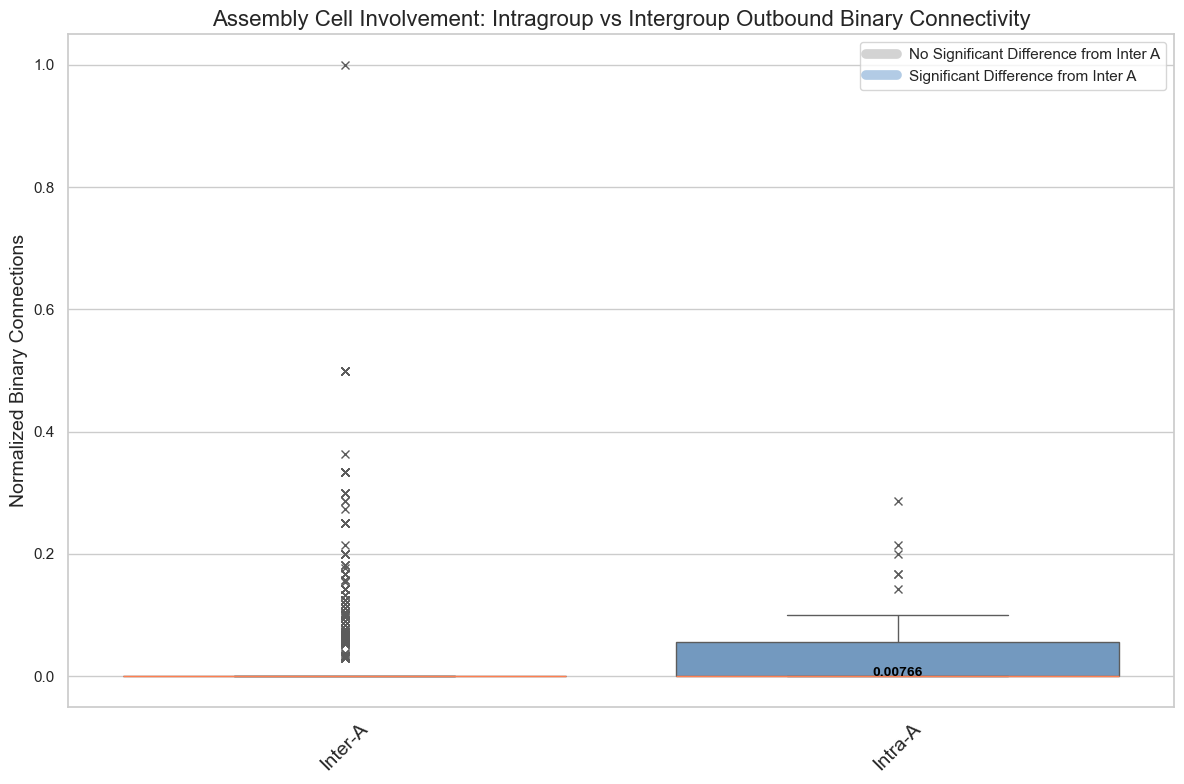

In [19]:
inter_vs_intra_connections_plot(input_connections_dict = outbound_binary_intra_vs_inter_first_order_connections,
                                     directionality = 'Outbound', 
                                     binary_counts = True,
                                     syn_counts = False, 
                                     summed_psd = False,
                                     average_psd = False, 
                                     show_p_vals = True)

/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_56595/299252119.py:72: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, size = 14)


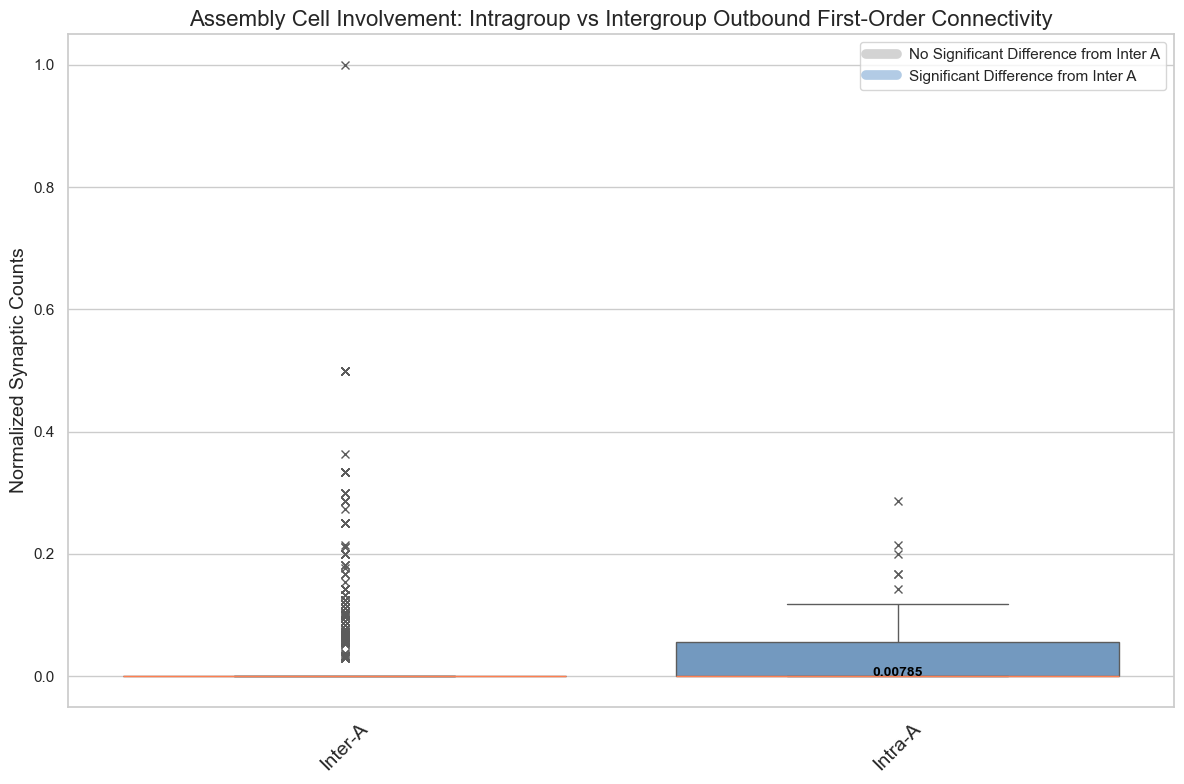

In [20]:
inter_vs_intra_connections_plot(input_connections_dict = outbound_syn_count_intra_vs_inter_first_order_connections,
                                     directionality = 'Outbound', 
                                     binary_counts = False,
                                     syn_counts = True, 
                                     summed_psd = False,
                                     average_psd = False, 
                                     show_p_vals = True)

/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_56595/299252119.py:72: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, size = 14)


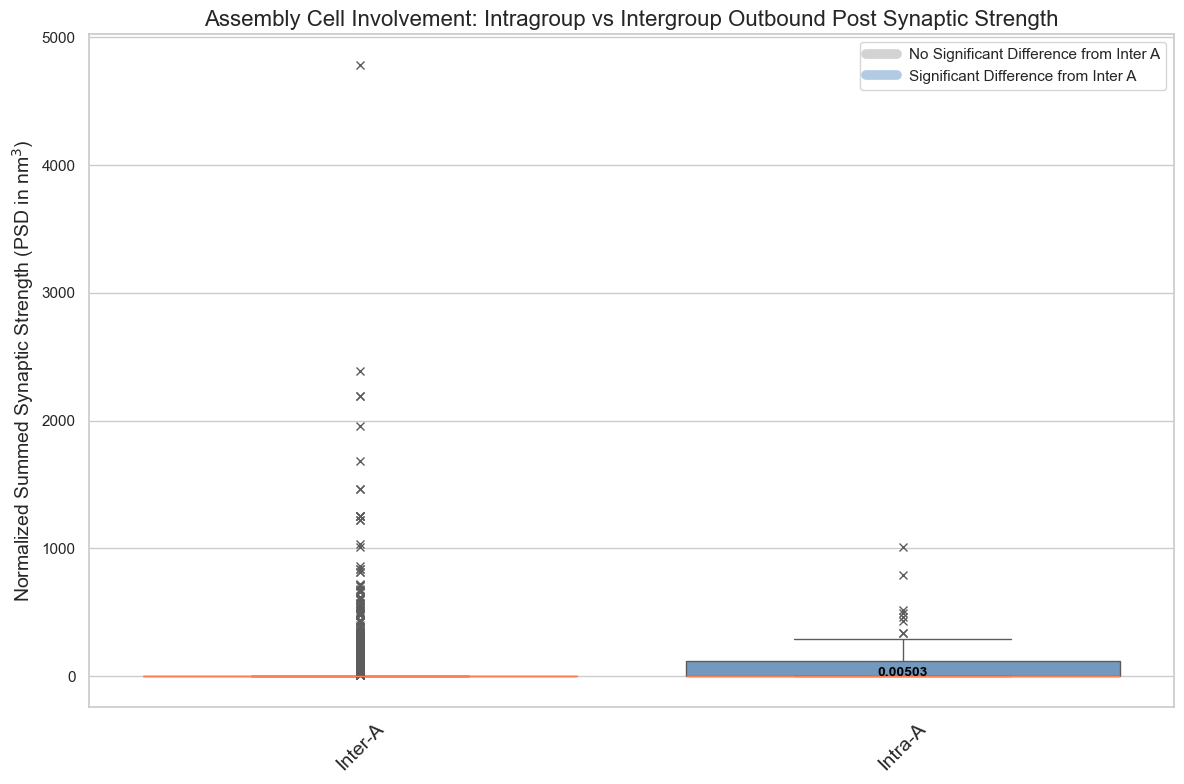

In [21]:
inter_vs_intra_connections_plot(input_connections_dict = outbound_summed_psd_intra_vs_inter_first_order_connections,
                                     directionality = 'Outbound', 
                                     binary_counts = False,
                                     syn_counts = False, 
                                     summed_psd = True,
                                     average_psd = False, 
                                     show_p_vals = True)

/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_56595/299252119.py:72: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, size = 14)


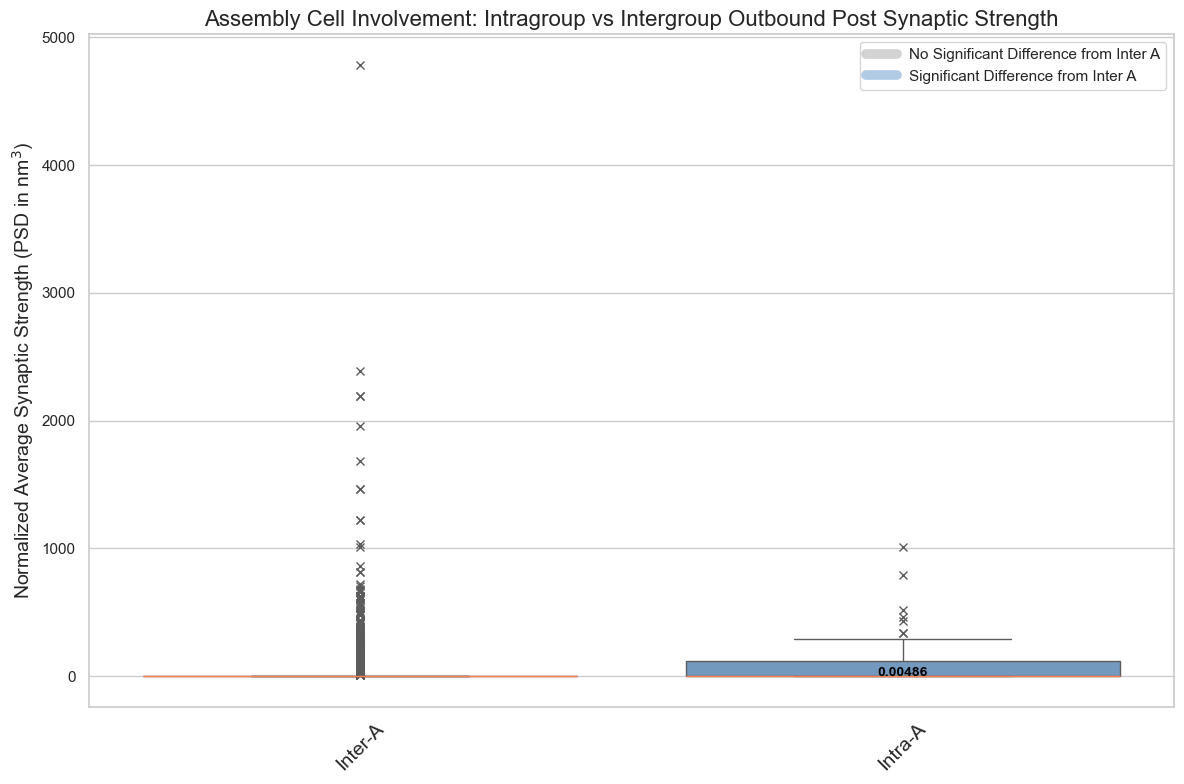

In [22]:
inter_vs_intra_connections_plot(input_connections_dict = outbound_average_psd_intra_vs_inter_first_order_connections,
                                     directionality = 'Outbound', 
                                     binary_counts = False,
                                     syn_counts = False, 
                                     summed_psd = False,
                                     average_psd = True, 
                                     show_p_vals = True)

/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_56595/299252119.py:72: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, size = 14)


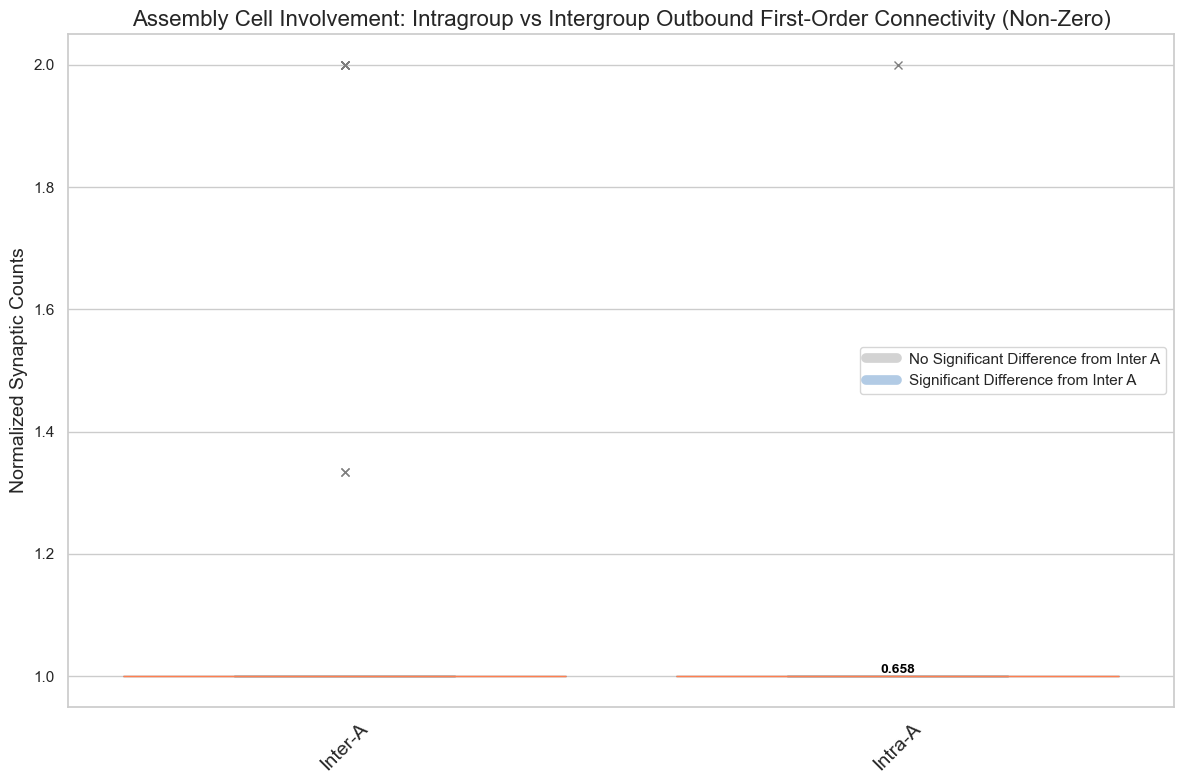

In [23]:
inter_vs_intra_connections_plot(input_connections_dict = non_zero_outbound_syn_count_intra_vs_inter_first_order_connections,
                                     directionality = 'Outbound', 
                                     binary_counts = False,
                                     syn_counts = True, 
                                     summed_psd = False,
                                     average_psd = False, 
                                     show_p_vals = True,
                                     consider_zero_connections = False)

/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_56595/299252119.py:72: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, size = 14)


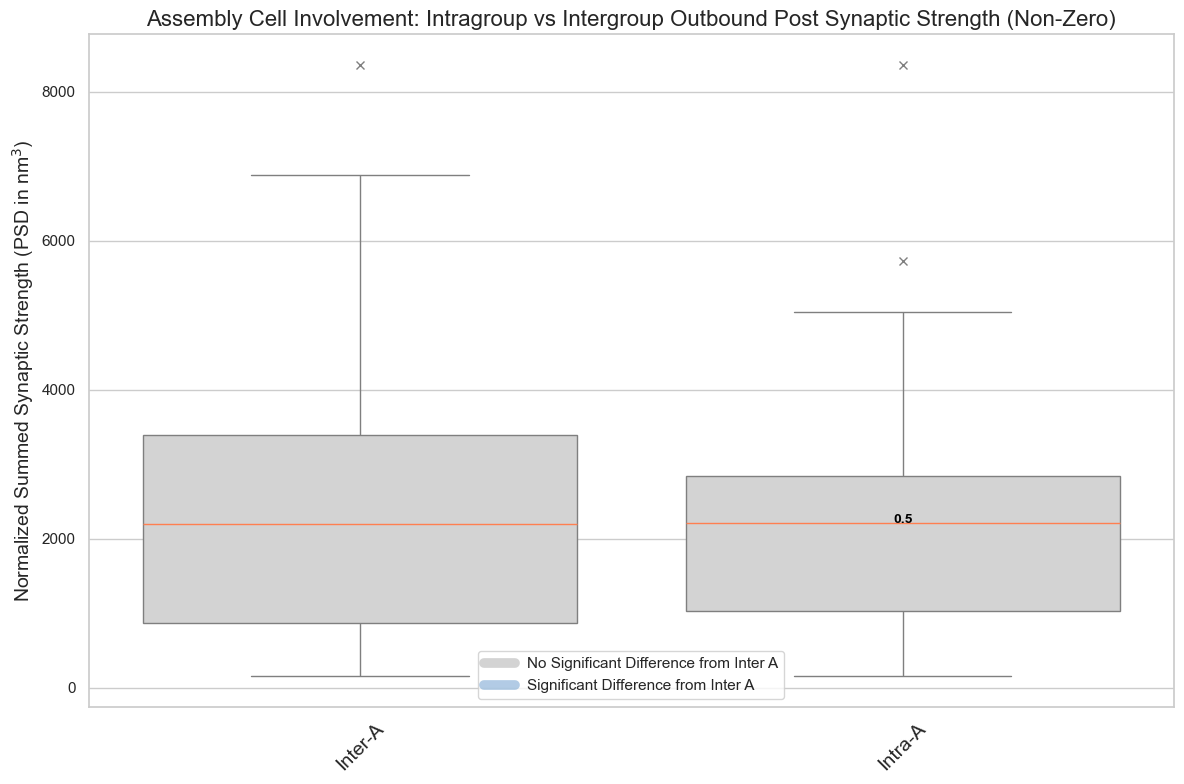

In [24]:
inter_vs_intra_connections_plot(input_connections_dict = non_zero_outbound_summed_psd_intra_vs_inter_first_order_connections,
                                     directionality = 'Outbound', 
                                     binary_counts = False,
                                     syn_counts = False, 
                                     summed_psd = True,
                                     average_psd = False, 
                                     show_p_vals = True,
                                     consider_zero_connections = False)

/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_56595/299252119.py:72: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, size = 14)


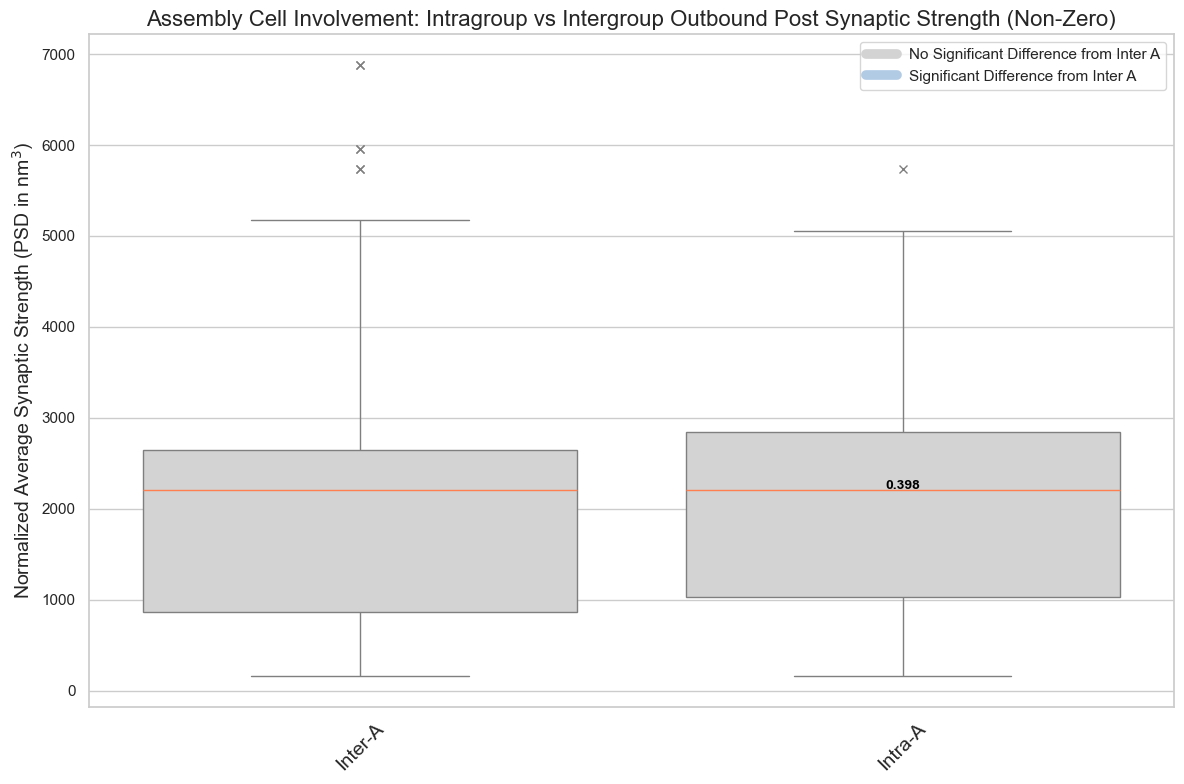

In [25]:
inter_vs_intra_connections_plot(input_connections_dict = non_zero_outbound_average_psd_intra_vs_inter_first_order_connections,
                                     directionality = 'Outbound', 
                                     binary_counts = False,
                                     syn_counts = False, 
                                     summed_psd = False,
                                     average_psd = True, 
                                     show_p_vals = True,
                                     consider_zero_connections = False)

In [26]:
zero_connection_count = 0
connection_count = 0
by_postcell_inbound_binary_intra_assembly_first_order = []
by_postcell_inbound_binary_inter_assembly_first_order = []
by_postcell_inbound_syn_count_intra_assembly_first_order = []
non_zero_by_postcell_inbound_syn_count_intra_assembly_first_order = []
by_postcell_inbound_syn_count_inter_assembly_first_order = []
non_zero_by_postcell_inbound_syn_count_inter_assembly_first_order = []
by_postcell_inbound_summed_psd_intra_assembly_first_order = []
non_zero_by_postcell_inbound_summed_psd_intra_assembly_first_order = []
by_postcell_inbound_summed_psd_inter_assembly_first_order = []
non_zero_by_postcell_inbound_summed_psd_inter_assembly_first_order = []
by_postcell_inbound_average_psd_intra_assembly_first_order = []
non_zero_by_postcell_inbound_average_psd_intra_assembly_first_order = []
by_postcell_inbound_average_psd_inter_assembly_first_order = []
non_zero_by_postcell_inbound_average_psd_inter_assembly_first_order = []
assemblies_by_coregistered_sans_no_a = {k: v for k, v in assemblies_by_coregistered.items() if k != 'No A'}
post_assemblies_by_coregistered_sans_no_a = {k: v for k, v in post_assemblies_by_coregistered.items() if k != 'No A'}

# Intra-Group
for pre_assembly, pre_cells in assemblies_by_coregistered_sans_no_a.items():
    actual_assembly_connections = 0
    post_cells = post_assemblies_by_coregistered_sans_no_a[pre_assembly]
    #initialize normalization constants
    all_possible_intra_connections = len(post_cells) * (len(pre_cells) - 1) #n*n-1
    possible_inbound_intra_group = (len(pre_cells) - 1) # n-1
    #print(possible_outbound_intra_group)
    
    for post_cell in post_cells:
        post_cell_connections = 0
        post_cell_syn_count = 0
        post_cell_summed_psd = 0
        post_cell_average_psd = 0
        post_cell_zeros = 0

        for pre_cell in pre_cells:
            if np.any(np.logical_and(two_chain_results_array[:, 0] == pre_cell, two_chain_results_array[:, -1] == post_cell)):
                # Pull connectivity from each connectome
                indv_cell_connection = 1 # binary connectome
                indv_syn_count = synapse_count_connectome[pre_cell, post_cell]
                indv_summed_psd_size = summed_size_connectome[pre_cell, post_cell]
                indv_average_psd_size = average_size_connectome[pre_cell, post_cell]
                # aggregate
                post_cell_connections += indv_cell_connection
                post_cell_syn_count += indv_syn_count
                post_cell_summed_psd += indv_summed_psd_size
                post_cell_average_psd += indv_average_psd_size
                actual_assembly_connections += 1
                connection_count += 1        
            else:
                post_cell_zeros += 1
                zero_connection_count += 1
        if (post_cell_zeros > 0 and post_cell_connections > 0):
            non_zero_by_postcell_inbound_syn_count_intra_assembly_first_order.append(post_cell_syn_count / post_cell_connections)
            non_zero_by_postcell_inbound_summed_psd_intra_assembly_first_order.append(post_cell_summed_psd / post_cell_connections)
            non_zero_by_postcell_inbound_average_psd_intra_assembly_first_order.append(post_cell_average_psd / post_cell_connections)
        if (possible_inbound_intra_group > 0):
            by_postcell_inbound_binary_intra_assembly_first_order.append(post_cell_connections / possible_inbound_intra_group)
            by_postcell_inbound_syn_count_intra_assembly_first_order.append(post_cell_syn_count / possible_inbound_intra_group)
            by_postcell_inbound_summed_psd_intra_assembly_first_order.append(post_cell_summed_psd / possible_inbound_intra_group)
            by_postcell_inbound_average_psd_intra_assembly_first_order.append(post_cell_average_psd / possible_inbound_intra_group) 

print(f"Pooled Intra-Assembly Connections: {connection_count} out of {zero_connection_count + connection_count} possible")

# Inter-Group
zero_connection_count = 0
connection_count = 0
for pre_assembly, pre_cells in assemblies_by_coregistered_sans_no_a.items():
    actual_assembly_connections = 0
    for post_assembly in post_assemblies_by_coregistered_sans_no_a.keys():
        if pre_assembly != post_assembly:

            ### Initialize normalization constants, long process that will be refactored later
            post_cells_in_pre_indexing = []
            for post_cell_index in post_assemblies_by_coregistered_sans_no_a[post_assembly]:
                post_root = mappings['post_connectome_index_to_root_id'][post_cell_index]
                try:
                    post_cells_in_pre_indexing.append(mappings['pt_root_id_to_connectome_index'][post_root])
                except(KeyError):
                    pass
            overlap_to_remove_in_pre = list(set(assemblies_by_coregistered_sans_no_a[pre_assembly]) & set(post_cells_in_pre_indexing))
            overlap_root_ids_to_remove = [mappings['connectome_index_to_root_id'][c] for c in overlap_to_remove_in_pre]
            overlap_indexes_to_remove = [mappings['pt_root_id_to_connectome_index'][r] for r in overlap_root_ids_to_remove]
            unique_post_indexes = post_assemblies_by_coregistered_sans_no_a[post_assembly]
            unique_pre_indexes = list(set(assemblies_by_coregistered_sans_no_a[pre_assembly]) - set(overlap_indexes_to_remove))

            possible_connections_inter_group = len(unique_post_indexes) * (len(unique_pre_indexes)) #n_1*n_2
            possible_inbound_connections_inter_group = len(unique_pre_indexes) # n_2

            for post_cell in unique_post_indexes:
                post_cell_connections = 0
                post_cell_syn_count = 0
                post_cell_summed_psd = 0
                post_cell_average_psd = 0
                post_cell_zeros = 0

                for pre_cell in unique_pre_indexes:
                    if np.any(np.logical_and(two_chain_results_array[:, 0] == pre_cell, two_chain_results_array[:, -1] == post_cell)):
                        # Pull connectivity from each connectome
                        indv_cell_connection = 1 # binary connectome
                        indv_syn_count = synapse_count_connectome[pre_cell, post_cell]
                        indv_summed_psd_size = summed_size_connectome[pre_cell, post_cell]
                        indv_average_psd_size = average_size_connectome[pre_cell, post_cell]
                        # aggregate
                        post_cell_connections += indv_cell_connection
                        post_cell_syn_count += indv_syn_count
                        post_cell_summed_psd += indv_summed_psd_size
                        post_cell_average_psd += indv_average_psd_size
                        actual_assembly_connections += 1
                        connection_count += 1        
                    else:
                        post_cell_zeros += 1
                        zero_connection_count += 1
                if (post_cell_zeros > 0 and post_cell_connections > 0):
                    non_zero_by_postcell_inbound_syn_count_inter_assembly_first_order.append(post_cell_syn_count / post_cell_connections)
                    non_zero_by_postcell_inbound_summed_psd_inter_assembly_first_order.append(post_cell_summed_psd / post_cell_connections)
                    non_zero_by_postcell_inbound_average_psd_inter_assembly_first_order.append(post_cell_average_psd / post_cell_connections)
                if (possible_inbound_connections_inter_group > 0):
                    by_postcell_inbound_binary_inter_assembly_first_order.append(post_cell_connections / possible_inbound_connections_inter_group)
                    by_postcell_inbound_syn_count_inter_assembly_first_order.append(post_cell_syn_count / possible_inbound_connections_inter_group)
                    by_postcell_inbound_summed_psd_inter_assembly_first_order.append(post_cell_summed_psd / possible_inbound_connections_inter_group)
                    by_postcell_inbound_average_psd_inter_assembly_first_order.append(post_cell_average_psd / possible_inbound_connections_inter_group) 
print(f"Pooled Inter-Assembly Connections: {connection_count} out of {zero_connection_count + connection_count} possible")


inbound_binary_intra_vs_inter_first_order_connections = {"Intra-A": by_postcell_inbound_binary_intra_assembly_first_order,
                                                          "Inter-A": by_postcell_inbound_binary_inter_assembly_first_order}
inbound_syn_count_intra_vs_inter_first_order_connections = {"Intra-A": by_postcell_inbound_syn_count_intra_assembly_first_order,
                                                              "Inter-A": by_postcell_inbound_syn_count_inter_assembly_first_order}
inbound_summed_psd_intra_vs_inter_first_order_connections = {"Intra-A": by_postcell_inbound_summed_psd_intra_assembly_first_order,
                                                              "Inter-A": by_postcell_inbound_summed_psd_inter_assembly_first_order}
inbound_average_psd_intra_vs_inter_first_order_connections = {"Intra-A": by_postcell_inbound_average_psd_intra_assembly_first_order,
                                                              "Inter-A": by_postcell_inbound_average_psd_inter_assembly_first_order}
non_zero_inbound_syn_count_intra_vs_inter_first_order_connections = {"Intra-A": non_zero_by_postcell_inbound_syn_count_intra_assembly_first_order,
                                                                        "Inter-A": non_zero_by_postcell_inbound_syn_count_inter_assembly_first_order}
non_zero_inbound_summed_psd_intra_vs_inter_first_order_connections = {"Intra-A": non_zero_by_postcell_inbound_summed_psd_intra_assembly_first_order,
                                                                        "Inter-A": non_zero_by_postcell_inbound_summed_psd_inter_assembly_first_order}
non_zero_inbound_average_psd_intra_vs_inter_first_order_connections = {"Intra-A": non_zero_by_postcell_inbound_average_psd_intra_assembly_first_order,
                                                                        "Inter-A": non_zero_by_postcell_inbound_average_psd_inter_assembly_first_order}

Pooled Intra-Assembly Connections: 49 out of 1610 possible
Pooled Inter-Assembly Connections: 274 out of 9365 possible


/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_56595/299252119.py:72: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, size = 14)


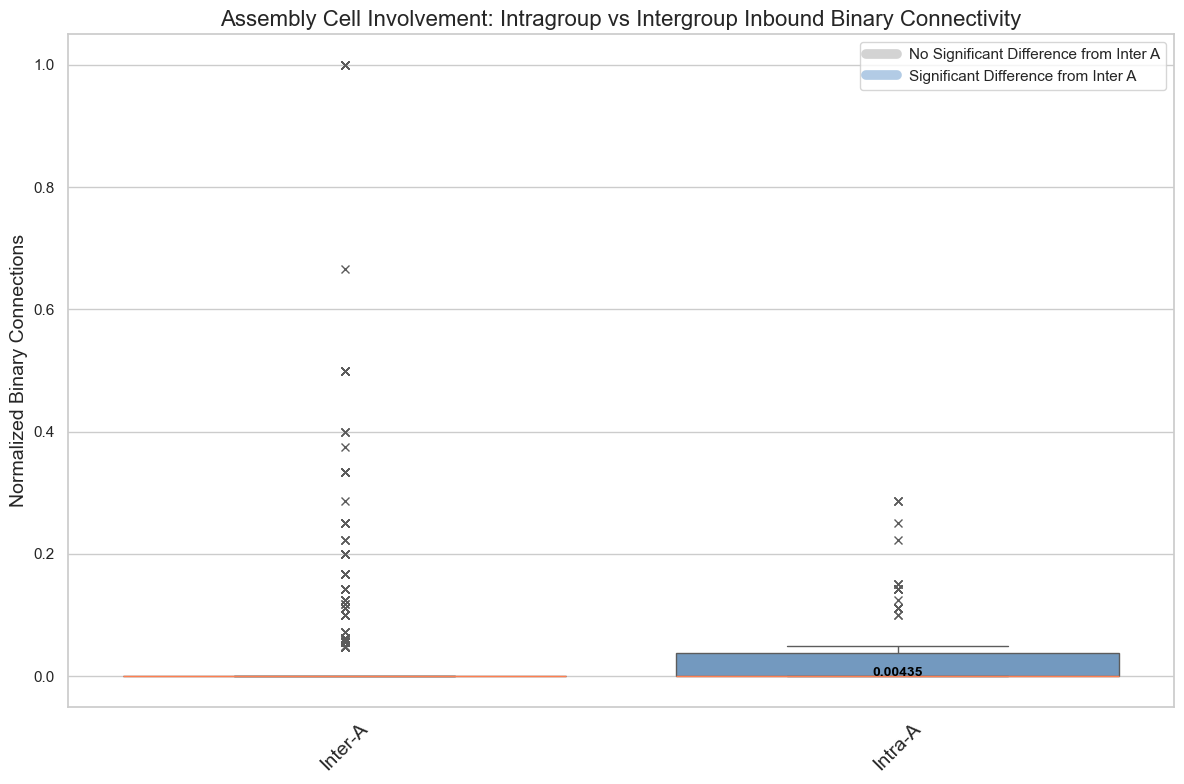

/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_56595/299252119.py:72: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, size = 14)


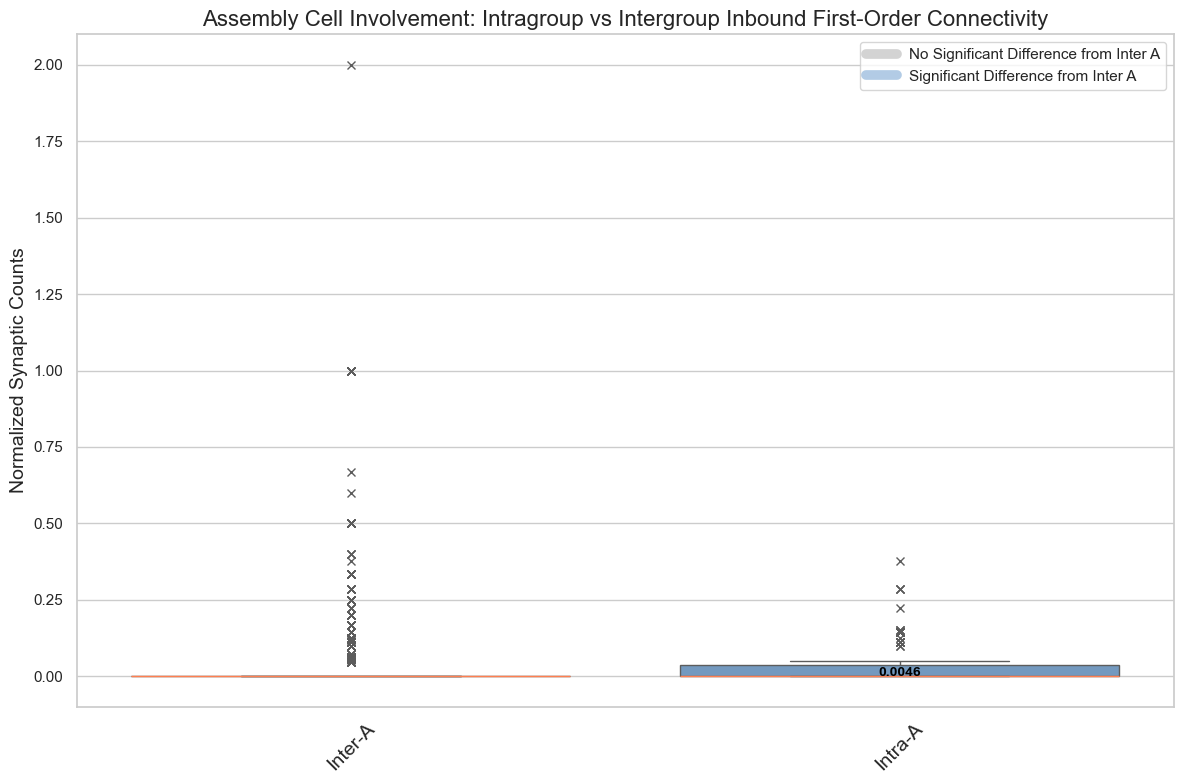

/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_56595/299252119.py:72: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, size = 14)


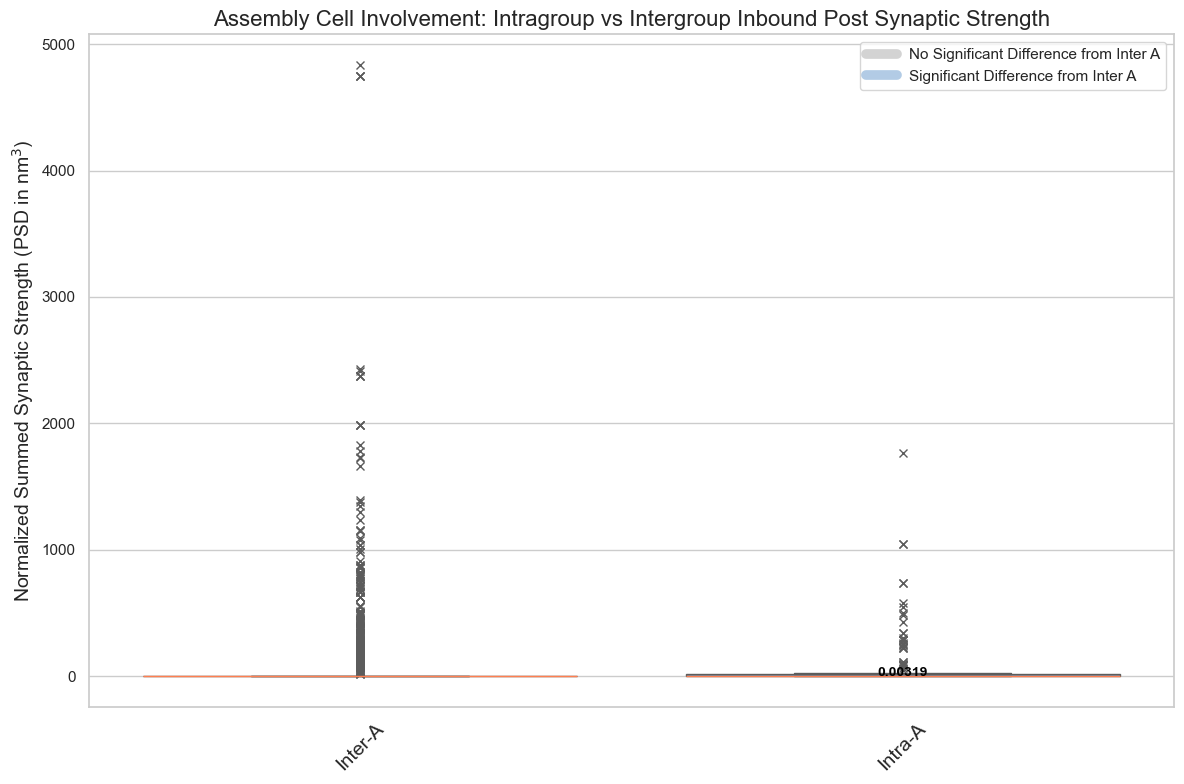

/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_56595/299252119.py:72: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, size = 14)


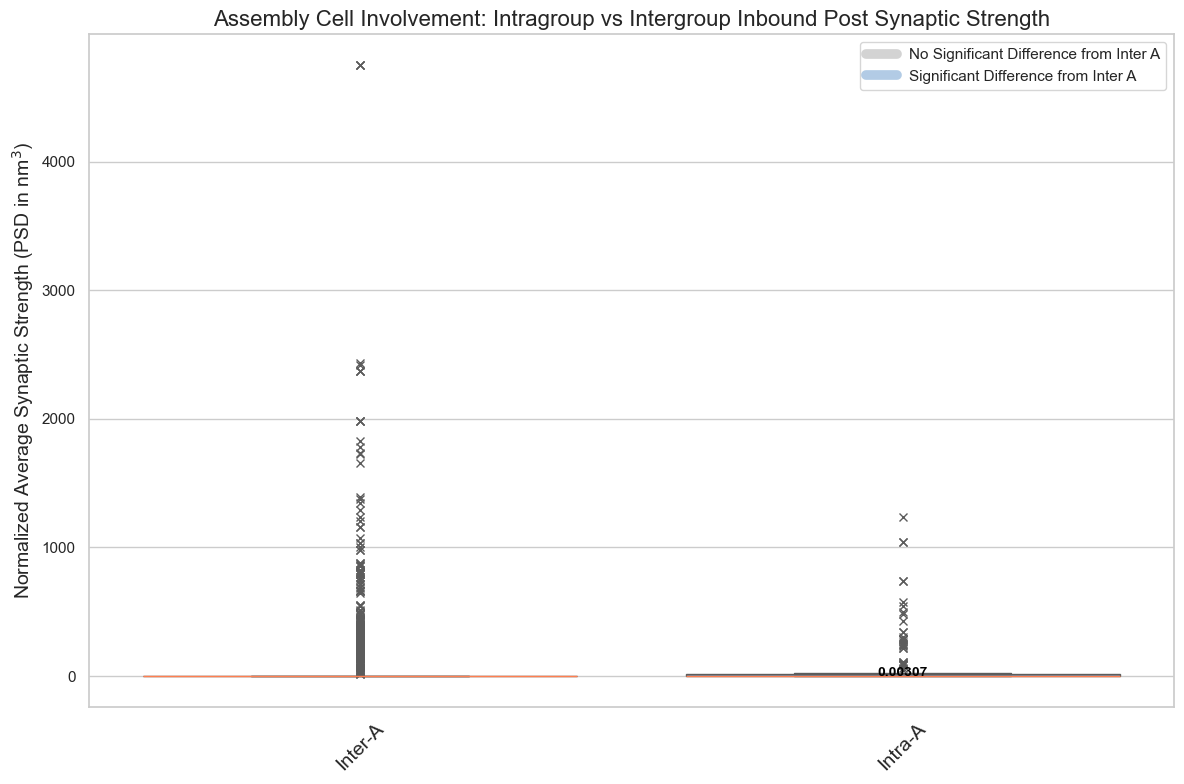

In [27]:
inter_vs_intra_connections_plot(input_connections_dict = inbound_binary_intra_vs_inter_first_order_connections,
                                     directionality = 'Inbound', 
                                     binary_counts = True,
                                     syn_counts = False, 
                                     summed_psd = False,
                                     average_psd = False, 
                                     show_p_vals = True)
inter_vs_intra_connections_plot(input_connections_dict = inbound_syn_count_intra_vs_inter_first_order_connections,
                                     directionality = 'Inbound', 
                                     binary_counts = False,
                                     syn_counts = True, 
                                     summed_psd = False,
                                     average_psd = False, 
                                     show_p_vals = True)
inter_vs_intra_connections_plot(input_connections_dict = inbound_summed_psd_intra_vs_inter_first_order_connections,
                                     directionality = 'Inbound', 
                                     binary_counts = False,
                                     syn_counts = False, 
                                     summed_psd = True,
                                     average_psd = False, 
                                     show_p_vals = True)
inter_vs_intra_connections_plot(input_connections_dict = inbound_average_psd_intra_vs_inter_first_order_connections,
                                     directionality = 'Inbound', 
                                     binary_counts = False,
                                     syn_counts = False, 
                                     summed_psd = False,
                                     average_psd = True, 
                                     show_p_vals = True)

/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_56595/299252119.py:72: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, size = 14)


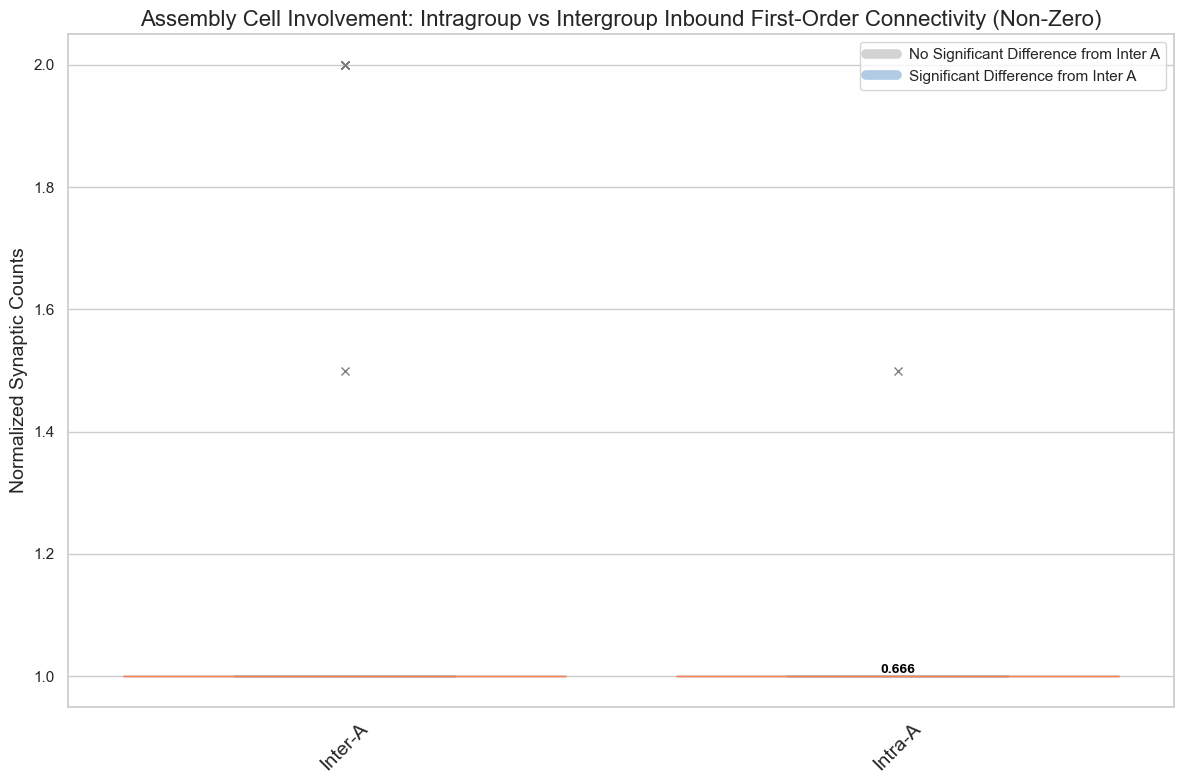

/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_56595/299252119.py:72: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, size = 14)


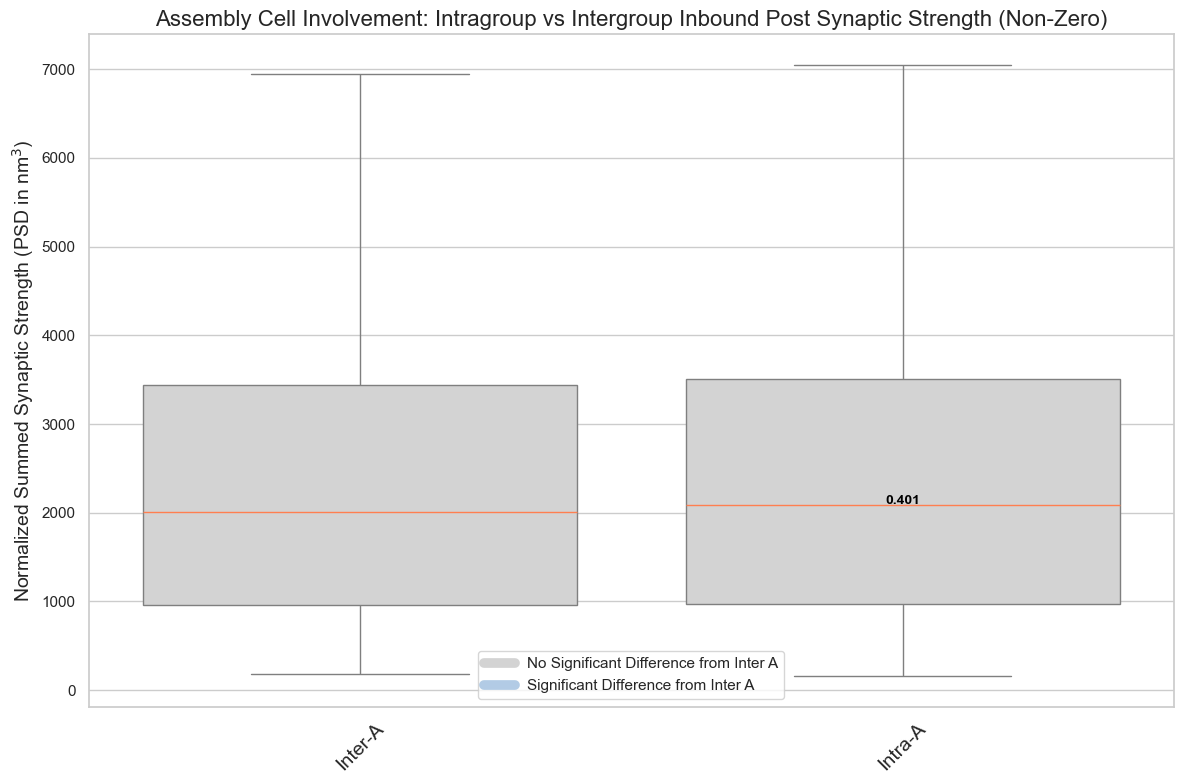

/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_56595/299252119.py:72: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, size = 14)


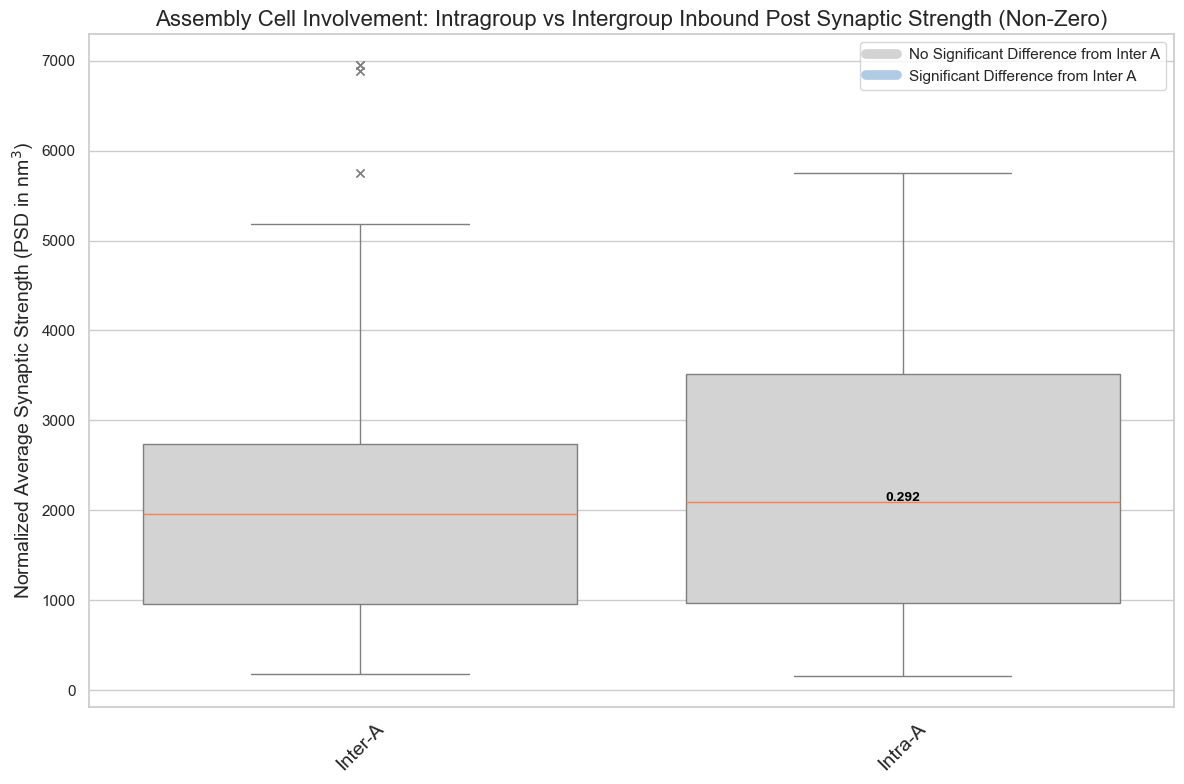

In [28]:
inter_vs_intra_connections_plot(input_connections_dict = non_zero_inbound_syn_count_intra_vs_inter_first_order_connections,
                                     directionality = 'Inbound', 
                                     binary_counts = False,
                                     syn_counts = True, 
                                     summed_psd = False,
                                     average_psd = False, 
                                     show_p_vals = True,
                                     consider_zero_connections = False)
inter_vs_intra_connections_plot(input_connections_dict = non_zero_inbound_summed_psd_intra_vs_inter_first_order_connections,
                                     directionality = 'Inbound', 
                                     binary_counts = False,
                                     syn_counts = False, 
                                     summed_psd = True,
                                     average_psd = False, 
                                     show_p_vals = True,
                                     consider_zero_connections = False)
inter_vs_intra_connections_plot(input_connections_dict = non_zero_inbound_average_psd_intra_vs_inter_first_order_connections,
                                     directionality = 'Inbound', 
                                     binary_counts = False,
                                     syn_counts = False, 
                                     summed_psd = False,
                                     average_psd = True, 
                                     show_p_vals = True,
                                     consider_zero_connections = False)

### Validating PSD Intra vs Inter Assembly (version 2)

In [ ]:
def inter_vs_intra_connections_plot(input_connections_dict: dict,
                                        directionality: str,
                                        binary_counts: bool,
                                        syn_counts: bool, 
                                        summed_psd : bool,
                                        average_psd: bool,
                                        show_p_vals: bool,
                                        consider_zero_connections = True):
    
    if binary_counts and syn_counts:
        raise ValueError("Must either be working with binary or synaptic count connectome.")
    if summed_psd and average_psd:
        raise ValueError("Must either be working with summed or average PSD values.")
    if (binary_counts or syn_counts) and (summed_psd or average_psd):
        raise ValueError("Must either be working with PSD or connectivity.")
    
    # Based on the connectome flags, save it in the right folder, set the correct y_label and plot title
    if binary_counts:
        connectome_desc = "Binary"
        folder = "binary_connectome"
        suffix = "Binary Connectivity"
        y_lab = "Normalized Binary Connections"
    elif summed_psd:
        connectome_desc = "Summed_PSD"
        folder = "summed_size_connectome"
        suffix = "Post Synaptic Strength"
        y_lab = "Normalized Summed Synaptic Strength (PSD in nm$^3$)"
    elif average_psd: 
        connectome_desc = "Average_PSD"
        folder = "average_size_connectome"
        suffix = "Post Synaptic Strength"
        y_lab = "Normalized Average Synaptic Strength (PSD in nm$^3$)"
    elif syn_counts:
        connectome_desc = "SynCounts"
        folder = "synapse_count_connectome"
        suffix = "First-Order Connectivity"
        y_lab = "Normalized Synaptic Counts"
    else:
        raise ValueError("Must specify which connectome is being used.")

    connections_dict = {}
    for key in input_connections_dict.keys():
        connections_dict[key] = np.array(input_connections_dict[key])

    suffix = f"Intragroup vs Intergroup {directionality} " + suffix
    connectome_desc = "Intra_vs_Inter_" + connectome_desc

    if not consider_zero_connections:
        suffix = suffix + " (Non-Zero)"
        connectome_desc = connectome_desc + "_Non_Zero_"

    # Establish Statistical Test
    all_arr = [connections_dict['Inter-A'], connections_dict['Intra-A']]
    x_ticks = ["Inter-A", 'Intra-A']
    arr_medians = [np.median(np.array(connections_dict['Inter-A'])), np.median(np.array(connections_dict['Intra-A']))]
    val = stats.ranksums(connections_dict['Intra-A'], connections_dict['Inter-A'], 'greater').pvalue
    p_values = [np.nan, '{:.3g}'.format(val, 5)]

    # Define Colors based on Signfiicance
    colors = ['lightgrey' if float(p_val) >= 0.05 or np.isnan(float(p_val)) else (.4, .6, .8, .5) for p_val in p_values]

    # Create a figure with specific size and Plot Results
    _, ax = plt.subplots(figsize=(12, 8))  # Width = 12 inches, Height = 6 inches
    sns.set_theme(style="whitegrid")
    sns.boxplot(data=all_arr,
                    notch= False, showcaps=True,
                    flierprops={"marker": "x"},
                    medianprops={"color": "coral"},
                    palette= colors,
                    ax = ax
                )
    ax.set_xticklabels(x_ticks, size = 14)
    ax.set_title(f'Assembly Cell Involvement: {suffix}', size = 16)
    ax.set_ylabel(y_lab, size = 14)
    plt.xticks(rotation=45)

    # Create legend
    custom_legend = [plt.Line2D([0], [0], color='lightgrey', lw=7, label='No Significant Difference from Inter A'),
                    plt.Line2D([0], [0], color=(.4, .6, .8, .5), lw=7, label='Significant Difference from Inter A')]
    plt.legend(handles=custom_legend, loc='best')

    # If you want to print P-Values, place them on the plot above the median

    if show_p_vals:
        medians = np.array(arr_medians)
        vertical_offset = medians * 0.005 # offset from median for display
            
        for xtick in ax.get_xticks():
            if xtick != 0:
                ax.text(xtick, medians[xtick] + vertical_offset[xtick], p_values[xtick],  # type: ignore
                        horizontalalignment='center', fontsize=10, color='black', weight='semibold')

    fig_title = f"Rectangular_Intra_vs_Inter_{directionality}_{connectome_desc}_Assemblies_Boxplot_v2.png"
    
    plt.savefig(f'{results_folder}/{folder}/{fig_title}', dpi = 1200)
    plt.tight_layout()
    plt.show()

In [18]:
mappings['assemblies_by_connectome_index']

{73: ['A 1'],
 102: ['A 1', 'A 3', 'A 4', 'A 5', 'A 7', 'A 8'],
 217: ['A 1'],
 119: ['A 1', 'A 5', 'A 7', 'A 10'],
 161: ['A 1', 'A 3'],
 204: ['A 1'],
 170: ['A 1', 'A 4', 'A 7', 'A 8'],
 213: ['A 1', 'A 4', 'A 7', 'A 8'],
 98: ['A 1', 'A 2', 'A 8'],
 171: ['A 1', 'A 3'],
 132: ['A 1'],
 159: ['A 1', 'A 3', 'A 5'],
 140: ['A 1', 'A 2', 'A 3'],
 44: ['A 1', 'A 6'],
 156: ['A 1'],
 203: ['A 1', 'A 4'],
 94: ['A 1', 'A 6'],
 196: ['A 1', 'A 3', 'A 4'],
 249: ['A 1', 'A 2'],
 55: ['A 1', 'A 6'],
 181: ['A 1', 'A 3', 'A 8'],
 198: ['A 2', 'A 11'],
 211: ['A 2'],
 160: ['A 2'],
 117: ['A 2', 'A 10'],
 251: ['A 2', 'A 4', 'A 5'],
 232: ['A 2', 'A 10'],
 107: ['A 3'],
 99: ['A 3', 'A 7', 'A 8'],
 224: ['A 3'],
 206: ['A 4'],
 144: ['A 4'],
 54: ['A 4', 'A 5', 'A 7', 'A 8'],
 276: ['A 4', 'A 5', 'A 7', 'A 8'],
 138: ['A 5', 'A 7'],
 78: ['A 5'],
 247: ['A 6'],
 173: ['A 9', 'A 12'],
 259: ['A 9'],
 256: ['A 10'],
 118: ['A 10'],
 129: ['A 13', 'A 15'],
 105: ['A 14'],
 123: ['No A'],
 86: ['N

In [18]:
coregistered_post_cell_indexes = mappings['assemblies_by_post_connectome_index'].keys()
coregistered_cell_indexes = mappings['assemblies_by_connectome_index'].keys()
no_a_cell_indexes = mappings['connectome_indexes_by_assembly']['No A']
no_a_post_cell_indexes = mappings['post_connectome_indexes_by_assembly']['No A']
pooled_assembly_indexes = list(set(coregistered_cell_indexes) - set(no_a_cell_indexes))
pooled_assembly_post_indexes = list(set(coregistered_post_cell_indexes) - set(no_a_post_cell_indexes))

In [33]:
### do calculus for no_assembly cells
by_pre_cell_outbound_binary_no_assembly_first_order = []
for pre_index in no_a_cell_indexes:
    pre_root_id = mappings['connectome_index_to_root_id'][pre_index]
    no_assembly_binary_connections = 0
    no_assembly_syn_counts = 0
    no_assembly_syn_counts = 0
    no_assembly_summed_psd = 0
    no_assembly_average_psd = 0

    for post_index in no_a_post_cell_indexes:
        post_root_id = mappings['post_connectome_index_to_root_id'][post_index]
        # No Autapses
        if pre_root_id == post_root_id:
            print(pre_index, post_index, pre_root_id, post_root_id)
            continue
        # Case where both pre and post are assigned to no assembly
        no_assembly_binary_connections += 1 
    by_pre_cell_outbound_binary_no_assembly_first_order.append(no_assembly_binary_connections)

### do calculus for assembly_cells
by_precell_outbound_binary_shared_assembly_first_order = []
by_precell_outbound_binary_disjoint_assembly_first_order = []

by_precell_outbound_syn_count_shared_assembly_first_order = []
non_zero_by_precell_outbound_syn_count_shared_assembly_first_order = []
by_precell_outbound_syn_count_disjoint_assembly_first_order = []
non_zero_by_precell_outbound_syn_count_disjoint_assembly_first_order = []

by_precell_outbound_summed_psd_shared_assembly_first_order = []
non_zero_by_precell_outbound_summed_psd_shared_assembly_first_order = []
by_precell_outbound_summed_psd_disjoint_assembly_first_order = []
non_zero_by_precell_outbound_summed_psd_disjoint_assembly_first_order = []

by_precell_outbound_average_psd_shared_assembly_first_order = []
non_zero_by_precell_outbound_average_psd_shared_assembly_first_order = []
by_precell_outbound_average_psd_disjoint_assembly_first_order = []
non_zero_by_precell_outbound_average_psd_disjoint_assembly_first_order = []

for pre_index in pooled_assembly_indexes:
    pre_root_id = mappings['connectome_index_to_root_id'][pre_index]
    pre_assembly_assignment = mappings['assemblies_by_connectome_index'][pre_index]

    shared_assembly_binary_connections = 0
    shared_assembly_non_zero_binary_connectins = 0
    disjoint_assembly_binary_connections = 0
    disjoint_assembly_non_zero_binary_connections = 0
    shared_assembly_syn_counts = 0
    disjoint_assembly_syn_counts = 0
    shared_assembly_summed_psd = 0
    disjoint_assembly_summed_psd = 0
    shared_assembly_average_psd = 0
    disjoint_assembly_average_psd = 0

    for post_index in pooled_assembly_post_indexes:
        post_root_id = mappings['post_connectome_index_to_root_id'][pre_index]
        post_assembly_assignment = mappings['assemblies_by_post_connectome_index'][post_index]

        # No Autapses
        if pre_root_id == post_root_id:
            print(pre_index, post_index, pre_root_id, post_root_id)
            continue

        # Check if there is a shared assignment
        has_shared_assignment = (not (set(pre_assembly_assignment).isdisjoint(post_assembly_assignment)))
        if has_shared_assignment:
            # Case where there is a connection
            if np.any(np.logical_and(two_chain_results_array[:, 0] == pre_cell, two_chain_results_array[:, -1] == post_cell)):
                shared_assembly_binary_connections += 1
                shared_assembly_syn_counts += summed_size_connectome[pre_index, post_index]
                shared_assembly_summed_psd += summed_size_connectome[pre_index, post_index]
                shared_assembly_average_psd += average_size_connectome[pre_index, post_index]
            # Case where there is no connection
            else:
                shared_assembly_non_zero_binary_connectins += 1
        # Case where there is no shared assignment (disjoint)
        else:
            # Case where there is a connection
            if np.any(np.logical_and(two_chain_results_array[:, 0] == pre_cell, two_chain_results_array[:, -1] == post_cell)):
                disjoint_assembly_binary_connections += 1
                disjoint_assembly_syn_counts += summed_size_connectome[pre_index, post_index]
                disjoint_assembly_summed_psd += summed_size_connectome[pre_index, post_index]
                disjoint_assembly_average_psd += average_size_connectome[pre_index, post_index]
            # Case where there is no connection
            else:
                disjoint_assembly_non_zero_binary_connections += 1
        
        # count possible connections
        shared_assembly_number_of_possible_posts = shared_assembly_binary_connections + shared_assembly_non_zero_binary_connectins
        disjoint_assembly_number_of_possible_post = disjoint_assembly_binary_connections + disjoint_assembly_non_zero_binary_connections


123 1449 864691132667436992 864691132667436992
86 1011 864691132841768198 864691132841768198
74 910 864691132680560211 864691132680560211
184 1981 864691132728579766 864691132728579766
150 1725 864691132748334211 864691132748334211
81 957 864691132746110031 864691132746110031
195 2210 864691132835126165 864691132835126165
158 1801 864691132641639590 864691132641639590
153 1745 864691132999886005 864691132999886005
71 900 864691132972662837 864691132972662837
41 620 864691132578187284 864691132578187284
207 2294 864691132741334425 864691132741334425


In [ ]:


assemblies_by_coregistered_sans_no_a = {k: v for k, v in assemblies_by_coregistered.items() if k != 'No A'}
post_assemblies_by_coregistered_sans_no_a = {k: v for k, v in post_assemblies_by_coregistered.items() if k != 'No A'}

# Intra-Group
for pre_assembly, pre_cells in assemblies_by_coregistered_sans_no_a.items():


    actual_assembly_connections = 0
    post_cells = post_assemblies_by_coregistered_sans_no_a[pre_assembly]
    #initialize normalization constants
    all_possible_intra_connections = len(pre_cells) * (len(post_cells) - 1) #n*n-1
    possible_outbound_intra_group = (len(post_cells) - 1) # n-1
    #print(possible_outbound_intra_group)
    
    for pre_cell in pre_cells:
        pre_cell_connections = 0
        pre_cell_syn_count = 0
        pre_cell_summed_psd = 0
        pre_cell_average_psd = 0
        pre_cell_zeros = 0

        for post_cell in post_cells:
            if np.any(np.logical_and(two_chain_results_array[:, 0] == pre_cell, two_chain_results_array[:, -1] == post_cell)):
                # Pull connectivity from each connectome
                indv_cell_connection = 1 # binary connectome
                indv_syn_count = synapse_count_connectome[pre_cell, post_cell]
                indv_summed_psd_size = summed_size_connectome[pre_cell, post_cell]
                indv_average_psd_size = average_size_connectome[pre_cell, post_cell]
                # aggregate
                pre_cell_connections += indv_cell_connection
                pre_cell_syn_count += indv_syn_count
                pre_cell_summed_psd += indv_summed_psd_size
                pre_cell_average_psd += indv_average_psd_size
                actual_assembly_connections += 1
                connection_count += 1        
            else:
                zero_connection_count += 1
                pre_cell_zeros += 1
        if (pre_cell_zeros > 0 and pre_cell_connections > 0):
            non_zero_by_precell_outbound_syn_count_intra_assembly_first_order.append(pre_cell_syn_count / pre_cell_connections)
            non_zero_by_precell_outbound_summed_psd_intra_assembly_first_order.append(pre_cell_summed_psd / pre_cell_connections)
            non_zero_by_precell_outbound_average_psd_intra_assembly_first_order.append(pre_cell_average_psd / pre_cell_connections)
        if (possible_outbound_intra_group > 0):
            by_precell_outbound_binary_intra_assembly_first_order.append(pre_cell_connections / possible_outbound_intra_group)
            by_precell_outbound_syn_count_intra_assembly_first_order.append(pre_cell_syn_count / possible_outbound_intra_group)
            by_precell_outbound_summed_psd_intra_assembly_first_order.append(pre_cell_summed_psd / possible_outbound_intra_group)
            by_precell_outbound_average_psd_intra_assembly_first_order.append(pre_cell_average_psd / possible_outbound_intra_group) 

print(f"Pooled Intra-Assembly Connections: {connection_count} out of {zero_connection_count + connection_count} possible")

# Inter-Group
zero_connection_count = 0
connection_count = 0
for pre_assembly, pre_cells in assemblies_by_coregistered_sans_no_a.items():
    actual_assembly_connections = 0
    for post_assembly in post_assemblies_by_coregistered_sans_no_a.keys():
        if pre_assembly != post_assembly:

            ### Initialize normalization constants, long process that will be refactored later
            post_cells_in_pre_indexing = []
            for post_cell_index in post_assemblies_by_coregistered_sans_no_a[post_assembly]:
                post_root = mappings['post_connectome_index_to_root_id'][post_cell_index]
                try:
                    post_cells_in_pre_indexing.append(mappings['pt_root_id_to_connectome_index'][post_root])
                except(KeyError):
                    pass
            overlap_to_remove_in_pre = list(set(assemblies_by_coregistered_sans_no_a[pre_assembly]) & set(post_cells_in_pre_indexing))
            overlap_root_ids_to_remove = [mappings['connectome_index_to_root_id'][c] for c in overlap_to_remove_in_pre]
            overlap_indexes_to_remove_in_post = [mappings['pt_root_id_to_post_connectome_index'][r] for r in overlap_root_ids_to_remove]
            unique_post_indexes_in_post = set(post_assemblies_by_coregistered_sans_no_a[post_assembly]) - set(overlap_indexes_to_remove_in_post)
            unique_post_indexes = unique_post_indexes_in_post
            possible_connections_inter_group = len(assemblies_by_coregistered_sans_no_a[pre_assembly]) * (len(unique_post_indexes)) #n_1*n_2
            possible_outbound_connections_inter_group = len(unique_post_indexes) # n_2
            # print(pre_assembly, post_assembly, possible_outbound_connections_inter_group)


            for pre_cell in pre_cells:
                pre_cell_connections = 0
                pre_cell_syn_count = 0
                pre_cell_summed_psd = 0
                pre_cell_average_psd = 0
                pre_cell_zeros = 0

                for post_cell in unique_post_indexes:
                    if np.any(np.logical_and(two_chain_results_array[:, 0] == pre_cell, two_chain_results_array[:, -1] == post_cell)):
                        # Pull connectivity from each connectome
                        indv_cell_connection = 1 # binary connectome
                        indv_syn_count = synapse_count_connectome[pre_cell, post_cell]
                        indv_summed_psd_size = summed_size_connectome[pre_cell, post_cell]
                        indv_average_psd_size = average_size_connectome[pre_cell, post_cell]
                        # aggregate
                        pre_cell_connections += indv_cell_connection
                        pre_cell_syn_count += indv_syn_count
                        pre_cell_summed_psd += indv_summed_psd_size
                        pre_cell_average_psd += indv_average_psd_size    
                        actual_assembly_connections += 1
                        connection_count += 1    
                    else:
                        zero_connection_count += 1
                        pre_cell_zeros += 1
                if (pre_cell_zeros > 0 and pre_cell_connections > 0):
                    non_zero_by_precell_outbound_syn_count_inter_assembly_first_order.append(pre_cell_syn_count / pre_cell_connections)
                    non_zero_by_precell_outbound_summed_psd_inter_assembly_first_order.append(pre_cell_summed_psd / pre_cell_connections)
                    non_zero_by_precell_outbound_average_psd_inter_assembly_first_order.append(pre_cell_average_psd / pre_cell_connections)
                if (possible_outbound_connections_inter_group > 0):
                    by_precell_outbound_binary_inter_assembly_first_order.append(pre_cell_connections / possible_outbound_connections_inter_group)
                    by_precell_outbound_syn_count_inter_assembly_first_order.append(pre_cell_syn_count / possible_outbound_connections_inter_group)
                    by_precell_outbound_summed_psd_inter_assembly_first_order.append(pre_cell_summed_psd / possible_outbound_connections_inter_group)
                    by_precell_outbound_average_psd_inter_assembly_first_order.append(pre_cell_average_psd / possible_outbound_connections_inter_group)
print(f"Pooled Inter-Assembly Connections: {connection_count} out of {zero_connection_count + connection_count} possible")


outbound_binary_intra_vs_inter_first_order_connections = {"Intra-A": by_precell_outbound_binary_intra_assembly_first_order,
                                                          "Inter-A": by_precell_outbound_binary_inter_assembly_first_order}
outbound_syn_count_intra_vs_inter_first_order_connections = {"Intra-A": by_precell_outbound_syn_count_intra_assembly_first_order,
                                                              "Inter-A": by_precell_outbound_syn_count_inter_assembly_first_order}
outbound_summed_psd_intra_vs_inter_first_order_connections = {"Intra-A": by_precell_outbound_summed_psd_intra_assembly_first_order,
                                                              "Inter-A": by_precell_outbound_summed_psd_inter_assembly_first_order}
outbound_average_psd_intra_vs_inter_first_order_connections = {"Intra-A": by_precell_outbound_average_psd_intra_assembly_first_order,
                                                              "Inter-A": by_precell_outbound_average_psd_inter_assembly_first_order}
non_zero_outbound_syn_count_intra_vs_inter_first_order_connections = {"Intra-A": non_zero_by_precell_outbound_syn_count_intra_assembly_first_order,
                                                                        "Inter-A": non_zero_by_precell_outbound_syn_count_inter_assembly_first_order}
non_zero_outbound_summed_psd_intra_vs_inter_first_order_connections = {"Intra-A": non_zero_by_precell_outbound_summed_psd_intra_assembly_first_order,
                                                                        "Inter-A": non_zero_by_precell_outbound_summed_psd_inter_assembly_first_order}
non_zero_outbound_average_psd_intra_vs_inter_first_order_connections = {"Intra-A": non_zero_by_precell_outbound_average_psd_intra_assembly_first_order,
                                                                        "Inter-A": non_zero_by_precell_outbound_average_psd_inter_assembly_first_order}

Pooled Intra-Assembly Connections: 49 out of 1610 possible
Pooled Inter-Assembly Connections: 326 out of 10466 possible


In [ ]:
print(len(by_precell_outbound_binary_intra_assembly_first_order))
print(len(by_precell_outbound_binary_inter_assembly_first_order))

88
1259


/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_56595/299252119.py:72: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, size = 14)


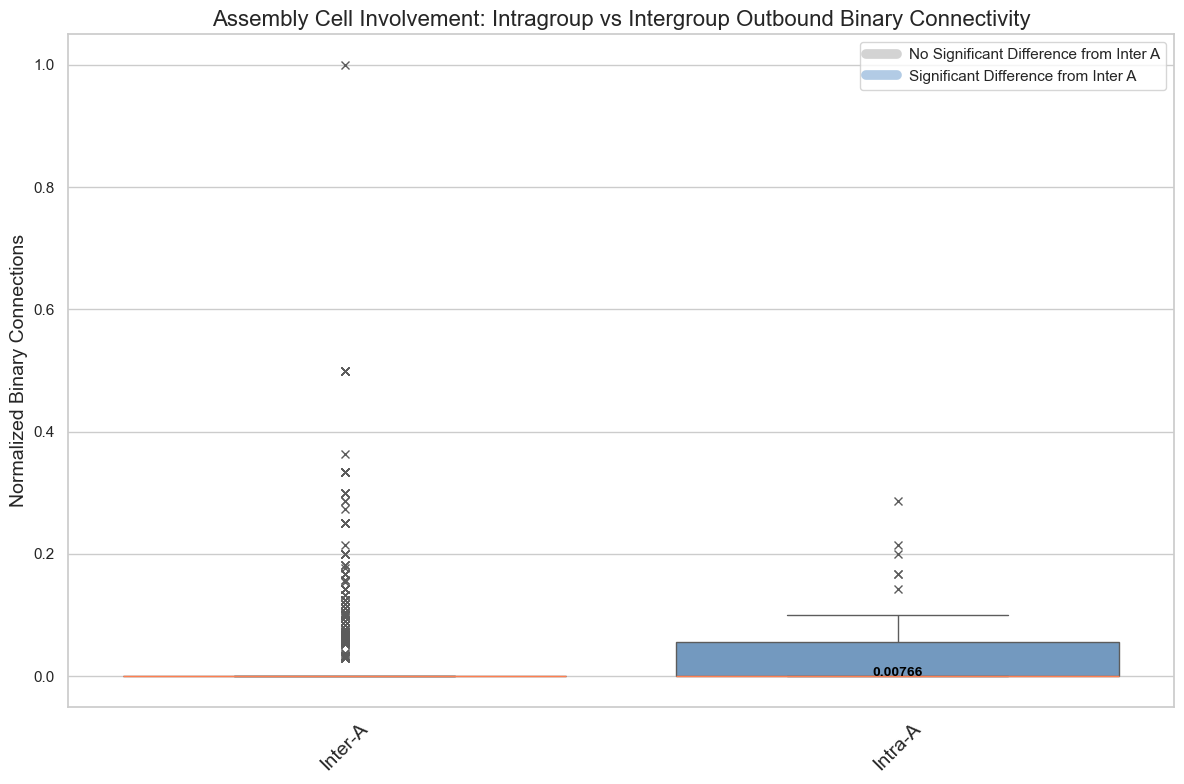

In [ ]:
inter_vs_intra_connections_plot(input_connections_dict = outbound_binary_intra_vs_inter_first_order_connections,
                                     directionality = 'Outbound', 
                                     binary_counts = True,
                                     syn_counts = False, 
                                     summed_psd = False,
                                     average_psd = False, 
                                     show_p_vals = True)

/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_56595/299252119.py:72: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, size = 14)


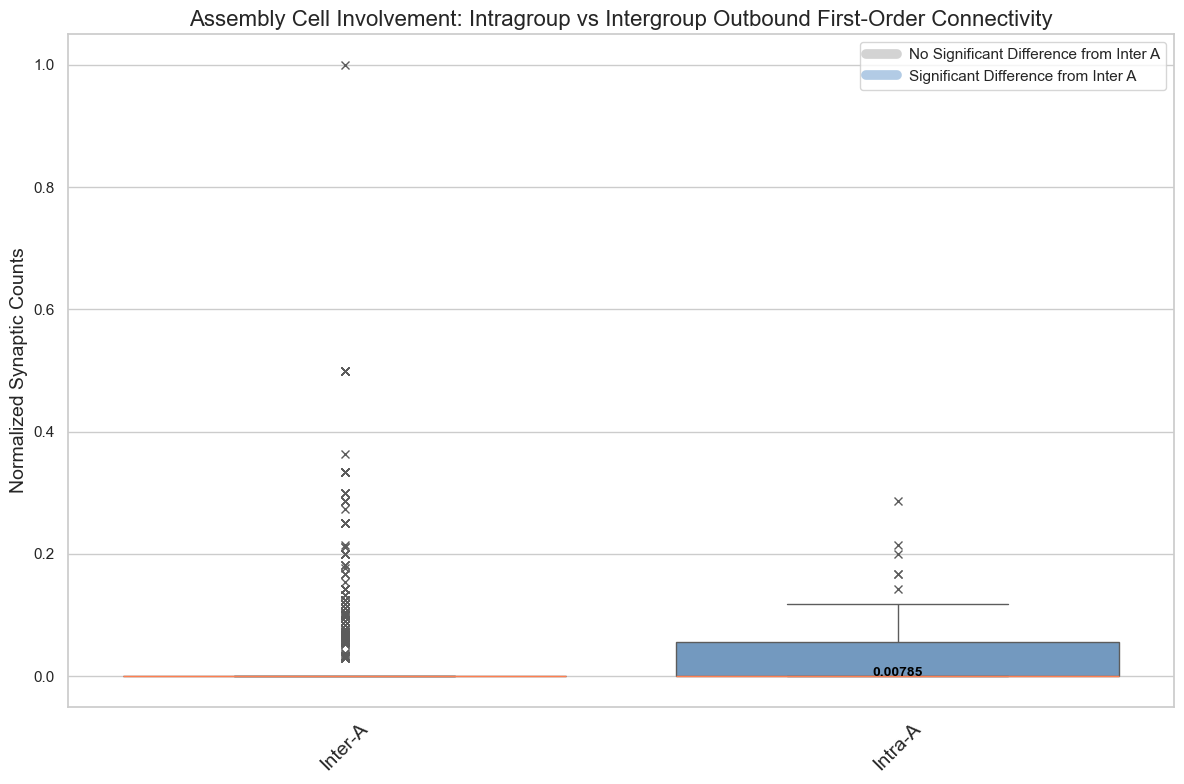

In [ ]:
inter_vs_intra_connections_plot(input_connections_dict = outbound_syn_count_intra_vs_inter_first_order_connections,
                                     directionality = 'Outbound', 
                                     binary_counts = False,
                                     syn_counts = True, 
                                     summed_psd = False,
                                     average_psd = False, 
                                     show_p_vals = True)

/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_56595/299252119.py:72: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, size = 14)


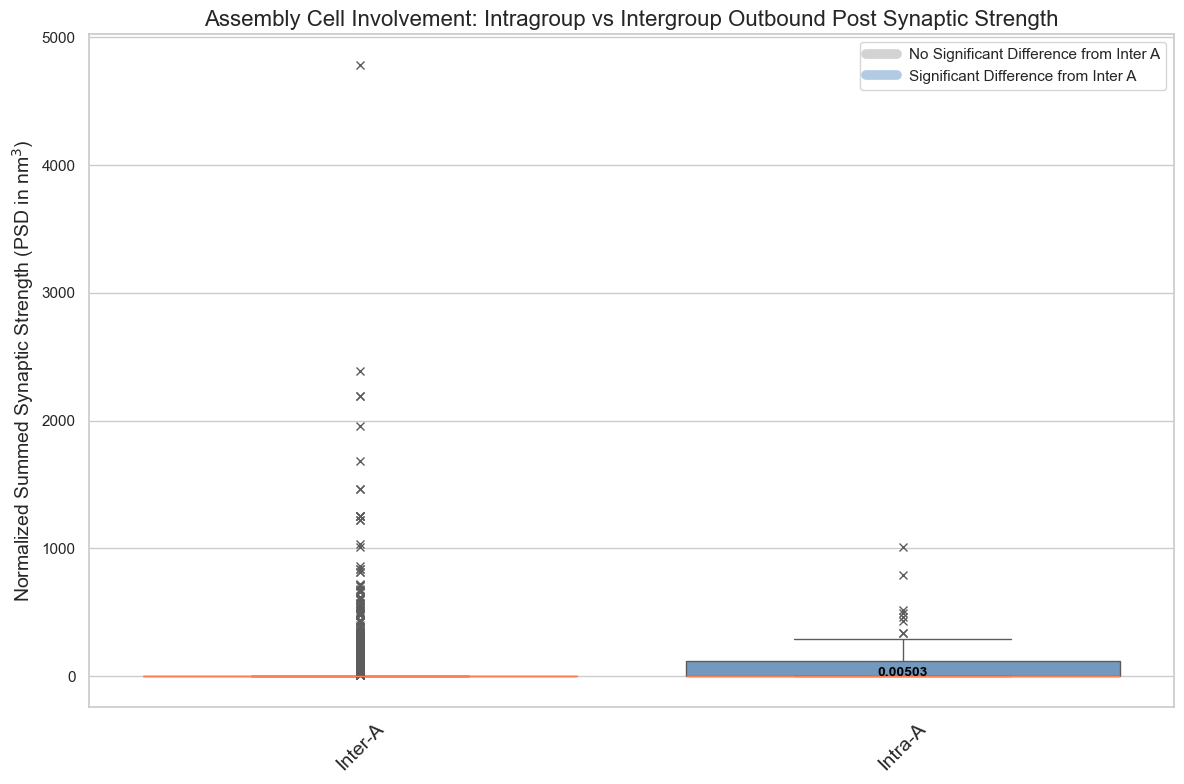

In [ ]:
inter_vs_intra_connections_plot(input_connections_dict = outbound_summed_psd_intra_vs_inter_first_order_connections,
                                     directionality = 'Outbound', 
                                     binary_counts = False,
                                     syn_counts = False, 
                                     summed_psd = True,
                                     average_psd = False, 
                                     show_p_vals = True)

/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_56595/299252119.py:72: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, size = 14)


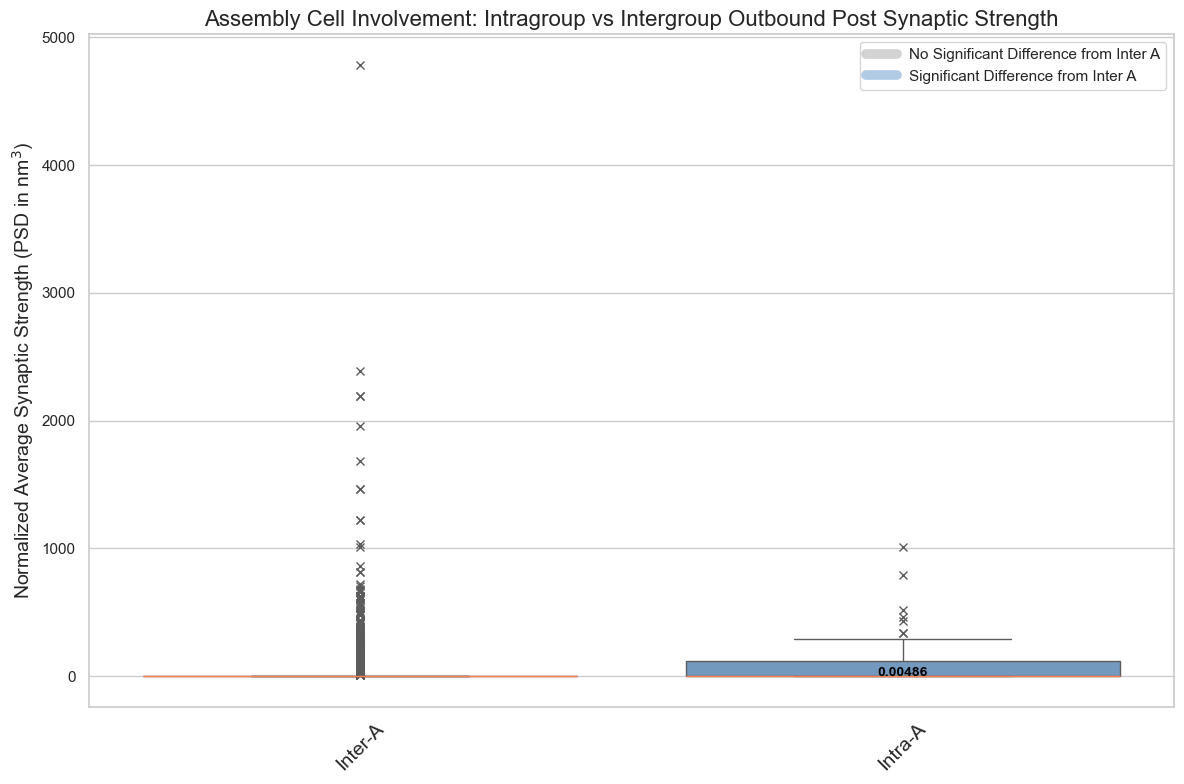

In [ ]:
inter_vs_intra_connections_plot(input_connections_dict = outbound_average_psd_intra_vs_inter_first_order_connections,
                                     directionality = 'Outbound', 
                                     binary_counts = False,
                                     syn_counts = False, 
                                     summed_psd = False,
                                     average_psd = True, 
                                     show_p_vals = True)

/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_56595/299252119.py:72: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, size = 14)


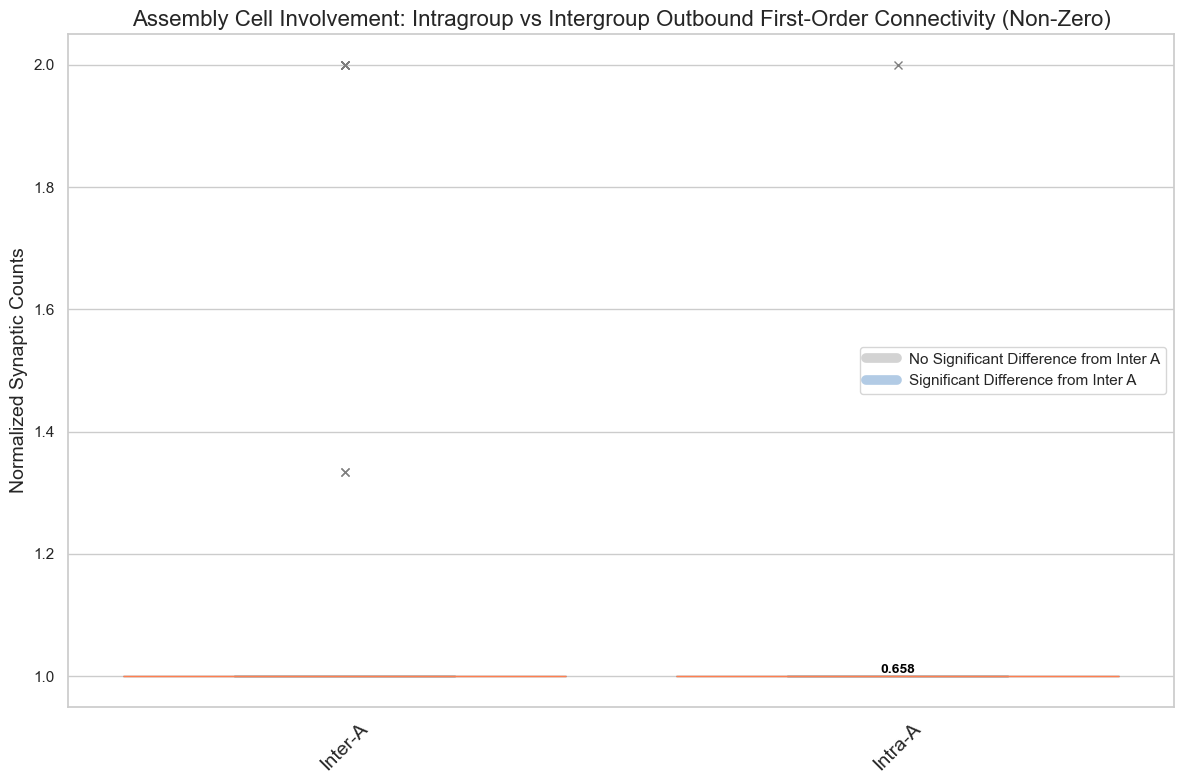

In [ ]:
inter_vs_intra_connections_plot(input_connections_dict = non_zero_outbound_syn_count_intra_vs_inter_first_order_connections,
                                     directionality = 'Outbound', 
                                     binary_counts = False,
                                     syn_counts = True, 
                                     summed_psd = False,
                                     average_psd = False, 
                                     show_p_vals = True,
                                     consider_zero_connections = False)

/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_56595/299252119.py:72: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, size = 14)


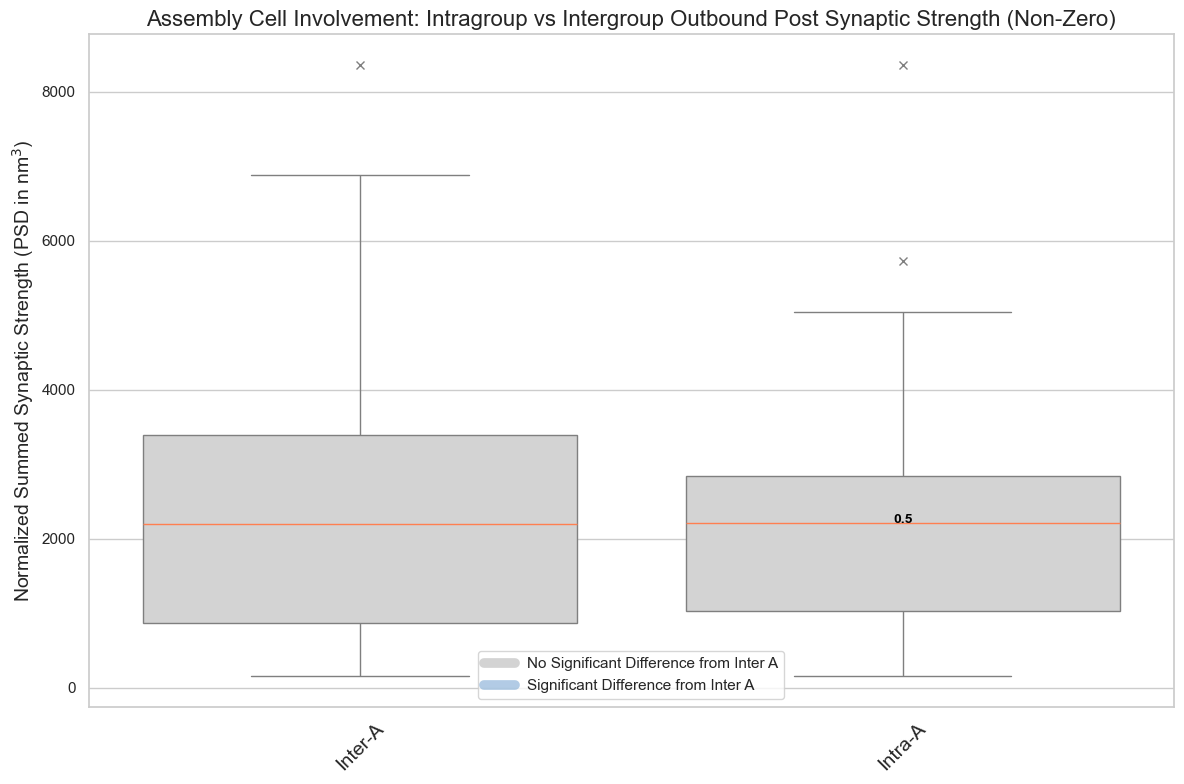

In [ ]:
inter_vs_intra_connections_plot(input_connections_dict = non_zero_outbound_summed_psd_intra_vs_inter_first_order_connections,
                                     directionality = 'Outbound', 
                                     binary_counts = False,
                                     syn_counts = False, 
                                     summed_psd = True,
                                     average_psd = False, 
                                     show_p_vals = True,
                                     consider_zero_connections = False)

/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_56595/299252119.py:72: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, size = 14)


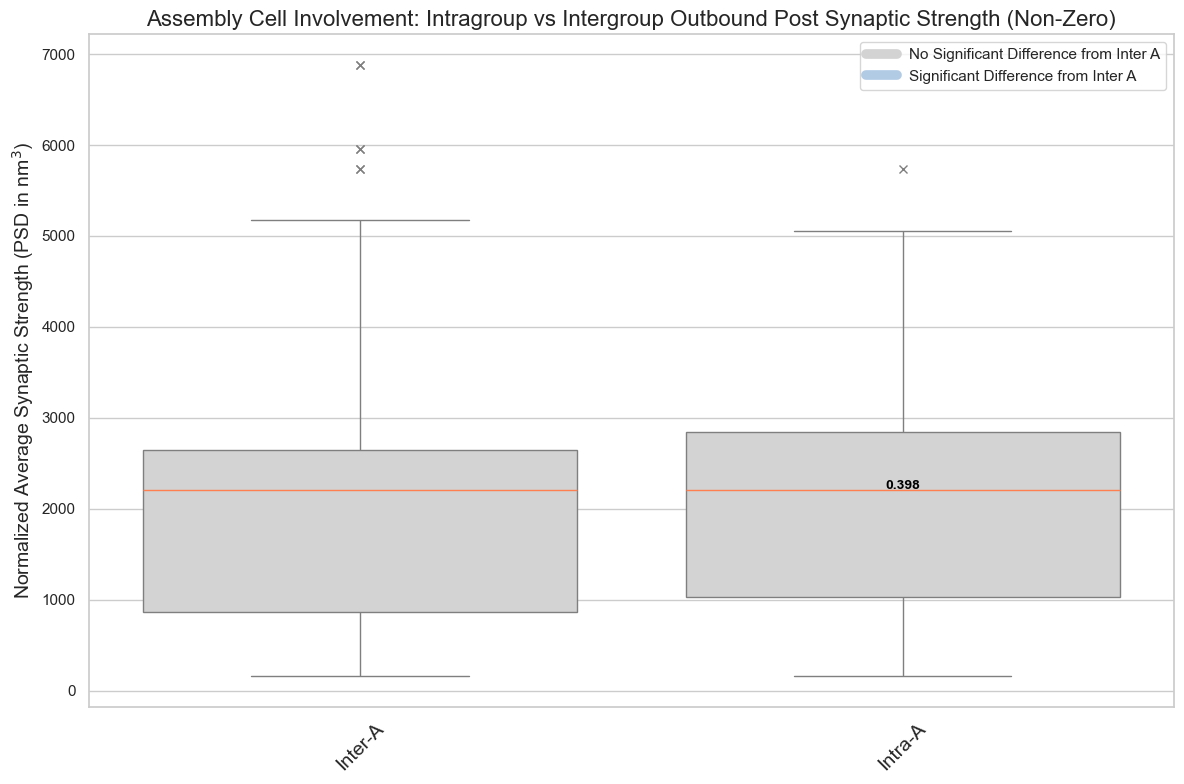

In [ ]:
inter_vs_intra_connections_plot(input_connections_dict = non_zero_outbound_average_psd_intra_vs_inter_first_order_connections,
                                     directionality = 'Outbound', 
                                     binary_counts = False,
                                     syn_counts = False, 
                                     summed_psd = False,
                                     average_psd = True, 
                                     show_p_vals = True,
                                     consider_zero_connections = False)

In [ ]:
zero_connection_count = 0
connection_count = 0
by_postcell_inbound_binary_intra_assembly_first_order = []
by_postcell_inbound_binary_inter_assembly_first_order = []
by_postcell_inbound_syn_count_intra_assembly_first_order = []
non_zero_by_postcell_inbound_syn_count_intra_assembly_first_order = []
by_postcell_inbound_syn_count_inter_assembly_first_order = []
non_zero_by_postcell_inbound_syn_count_inter_assembly_first_order = []
by_postcell_inbound_summed_psd_intra_assembly_first_order = []
non_zero_by_postcell_inbound_summed_psd_intra_assembly_first_order = []
by_postcell_inbound_summed_psd_inter_assembly_first_order = []
non_zero_by_postcell_inbound_summed_psd_inter_assembly_first_order = []
by_postcell_inbound_average_psd_intra_assembly_first_order = []
non_zero_by_postcell_inbound_average_psd_intra_assembly_first_order = []
by_postcell_inbound_average_psd_inter_assembly_first_order = []
non_zero_by_postcell_inbound_average_psd_inter_assembly_first_order = []
assemblies_by_coregistered_sans_no_a = {k: v for k, v in assemblies_by_coregistered.items() if k != 'No A'}
post_assemblies_by_coregistered_sans_no_a = {k: v for k, v in post_assemblies_by_coregistered.items() if k != 'No A'}

# Intra-Group
for pre_assembly, pre_cells in assemblies_by_coregistered_sans_no_a.items():
    actual_assembly_connections = 0
    post_cells = post_assemblies_by_coregistered_sans_no_a[pre_assembly]
    #initialize normalization constants
    all_possible_intra_connections = len(post_cells) * (len(pre_cells) - 1) #n*n-1
    possible_inbound_intra_group = (len(pre_cells) - 1) # n-1
    #print(possible_outbound_intra_group)
    
    for post_cell in post_cells:
        post_cell_connections = 0
        post_cell_syn_count = 0
        post_cell_summed_psd = 0
        post_cell_average_psd = 0
        post_cell_zeros = 0

        for pre_cell in pre_cells:
            if np.any(np.logical_and(two_chain_results_array[:, 0] == pre_cell, two_chain_results_array[:, -1] == post_cell)):
                # Pull connectivity from each connectome
                indv_cell_connection = 1 # binary connectome
                indv_syn_count = synapse_count_connectome[pre_cell, post_cell]
                indv_summed_psd_size = summed_size_connectome[pre_cell, post_cell]
                indv_average_psd_size = average_size_connectome[pre_cell, post_cell]
                # aggregate
                post_cell_connections += indv_cell_connection
                post_cell_syn_count += indv_syn_count
                post_cell_summed_psd += indv_summed_psd_size
                post_cell_average_psd += indv_average_psd_size
                actual_assembly_connections += 1
                connection_count += 1        
            else:
                post_cell_zeros += 1
                zero_connection_count += 1
        if (post_cell_zeros > 0 and post_cell_connections > 0):
            non_zero_by_postcell_inbound_syn_count_intra_assembly_first_order.append(post_cell_syn_count / post_cell_connections)
            non_zero_by_postcell_inbound_summed_psd_intra_assembly_first_order.append(post_cell_summed_psd / post_cell_connections)
            non_zero_by_postcell_inbound_average_psd_intra_assembly_first_order.append(post_cell_average_psd / post_cell_connections)
        if (possible_inbound_intra_group > 0):
            by_postcell_inbound_binary_intra_assembly_first_order.append(post_cell_connections / possible_inbound_intra_group)
            by_postcell_inbound_syn_count_intra_assembly_first_order.append(post_cell_syn_count / possible_inbound_intra_group)
            by_postcell_inbound_summed_psd_intra_assembly_first_order.append(post_cell_summed_psd / possible_inbound_intra_group)
            by_postcell_inbound_average_psd_intra_assembly_first_order.append(post_cell_average_psd / possible_inbound_intra_group) 

print(f"Pooled Intra-Assembly Connections: {connection_count} out of {zero_connection_count + connection_count} possible")

# Inter-Group
zero_connection_count = 0
connection_count = 0
for pre_assembly, pre_cells in assemblies_by_coregistered_sans_no_a.items():
    actual_assembly_connections = 0
    for post_assembly in post_assemblies_by_coregistered_sans_no_a.keys():
        if pre_assembly != post_assembly:

            ### Initialize normalization constants, long process that will be refactored later
            post_cells_in_pre_indexing = []
            for post_cell_index in post_assemblies_by_coregistered_sans_no_a[post_assembly]:
                post_root = mappings['post_connectome_index_to_root_id'][post_cell_index]
                try:
                    post_cells_in_pre_indexing.append(mappings['pt_root_id_to_connectome_index'][post_root])
                except(KeyError):
                    pass
            overlap_to_remove_in_pre = list(set(assemblies_by_coregistered_sans_no_a[pre_assembly]) & set(post_cells_in_pre_indexing))
            overlap_root_ids_to_remove = [mappings['connectome_index_to_root_id'][c] for c in overlap_to_remove_in_pre]
            overlap_indexes_to_remove = [mappings['pt_root_id_to_connectome_index'][r] for r in overlap_root_ids_to_remove]
            unique_post_indexes = post_assemblies_by_coregistered_sans_no_a[post_assembly]
            unique_pre_indexes = list(set(assemblies_by_coregistered_sans_no_a[pre_assembly]) - set(overlap_indexes_to_remove))

            possible_connections_inter_group = len(unique_post_indexes) * (len(unique_pre_indexes)) #n_1*n_2
            possible_inbound_connections_inter_group = len(unique_pre_indexes) # n_2

            for post_cell in unique_post_indexes:
                post_cell_connections = 0
                post_cell_syn_count = 0
                post_cell_summed_psd = 0
                post_cell_average_psd = 0
                post_cell_zeros = 0

                for pre_cell in unique_pre_indexes:
                    if np.any(np.logical_and(two_chain_results_array[:, 0] == pre_cell, two_chain_results_array[:, -1] == post_cell)):
                        # Pull connectivity from each connectome
                        indv_cell_connection = 1 # binary connectome
                        indv_syn_count = synapse_count_connectome[pre_cell, post_cell]
                        indv_summed_psd_size = summed_size_connectome[pre_cell, post_cell]
                        indv_average_psd_size = average_size_connectome[pre_cell, post_cell]
                        # aggregate
                        post_cell_connections += indv_cell_connection
                        post_cell_syn_count += indv_syn_count
                        post_cell_summed_psd += indv_summed_psd_size
                        post_cell_average_psd += indv_average_psd_size
                        actual_assembly_connections += 1
                        connection_count += 1        
                    else:
                        post_cell_zeros += 1
                        zero_connection_count += 1
                if (post_cell_zeros > 0 and post_cell_connections > 0):
                    non_zero_by_postcell_inbound_syn_count_inter_assembly_first_order.append(post_cell_syn_count / post_cell_connections)
                    non_zero_by_postcell_inbound_summed_psd_inter_assembly_first_order.append(post_cell_summed_psd / post_cell_connections)
                    non_zero_by_postcell_inbound_average_psd_inter_assembly_first_order.append(post_cell_average_psd / post_cell_connections)
                if (possible_inbound_connections_inter_group > 0):
                    by_postcell_inbound_binary_inter_assembly_first_order.append(post_cell_connections / possible_inbound_connections_inter_group)
                    by_postcell_inbound_syn_count_inter_assembly_first_order.append(post_cell_syn_count / possible_inbound_connections_inter_group)
                    by_postcell_inbound_summed_psd_inter_assembly_first_order.append(post_cell_summed_psd / possible_inbound_connections_inter_group)
                    by_postcell_inbound_average_psd_inter_assembly_first_order.append(post_cell_average_psd / possible_inbound_connections_inter_group) 
print(f"Pooled Inter-Assembly Connections: {connection_count} out of {zero_connection_count + connection_count} possible")


inbound_binary_intra_vs_inter_first_order_connections = {"Intra-A": by_postcell_inbound_binary_intra_assembly_first_order,
                                                          "Inter-A": by_postcell_inbound_binary_inter_assembly_first_order}
inbound_syn_count_intra_vs_inter_first_order_connections = {"Intra-A": by_postcell_inbound_syn_count_intra_assembly_first_order,
                                                              "Inter-A": by_postcell_inbound_syn_count_inter_assembly_first_order}
inbound_summed_psd_intra_vs_inter_first_order_connections = {"Intra-A": by_postcell_inbound_summed_psd_intra_assembly_first_order,
                                                              "Inter-A": by_postcell_inbound_summed_psd_inter_assembly_first_order}
inbound_average_psd_intra_vs_inter_first_order_connections = {"Intra-A": by_postcell_inbound_average_psd_intra_assembly_first_order,
                                                              "Inter-A": by_postcell_inbound_average_psd_inter_assembly_first_order}
non_zero_inbound_syn_count_intra_vs_inter_first_order_connections = {"Intra-A": non_zero_by_postcell_inbound_syn_count_intra_assembly_first_order,
                                                                        "Inter-A": non_zero_by_postcell_inbound_syn_count_inter_assembly_first_order}
non_zero_inbound_summed_psd_intra_vs_inter_first_order_connections = {"Intra-A": non_zero_by_postcell_inbound_summed_psd_intra_assembly_first_order,
                                                                        "Inter-A": non_zero_by_postcell_inbound_summed_psd_inter_assembly_first_order}
non_zero_inbound_average_psd_intra_vs_inter_first_order_connections = {"Intra-A": non_zero_by_postcell_inbound_average_psd_intra_assembly_first_order,
                                                                        "Inter-A": non_zero_by_postcell_inbound_average_psd_inter_assembly_first_order}

Pooled Intra-Assembly Connections: 49 out of 1610 possible
Pooled Inter-Assembly Connections: 274 out of 9365 possible


/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_56595/299252119.py:72: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, size = 14)


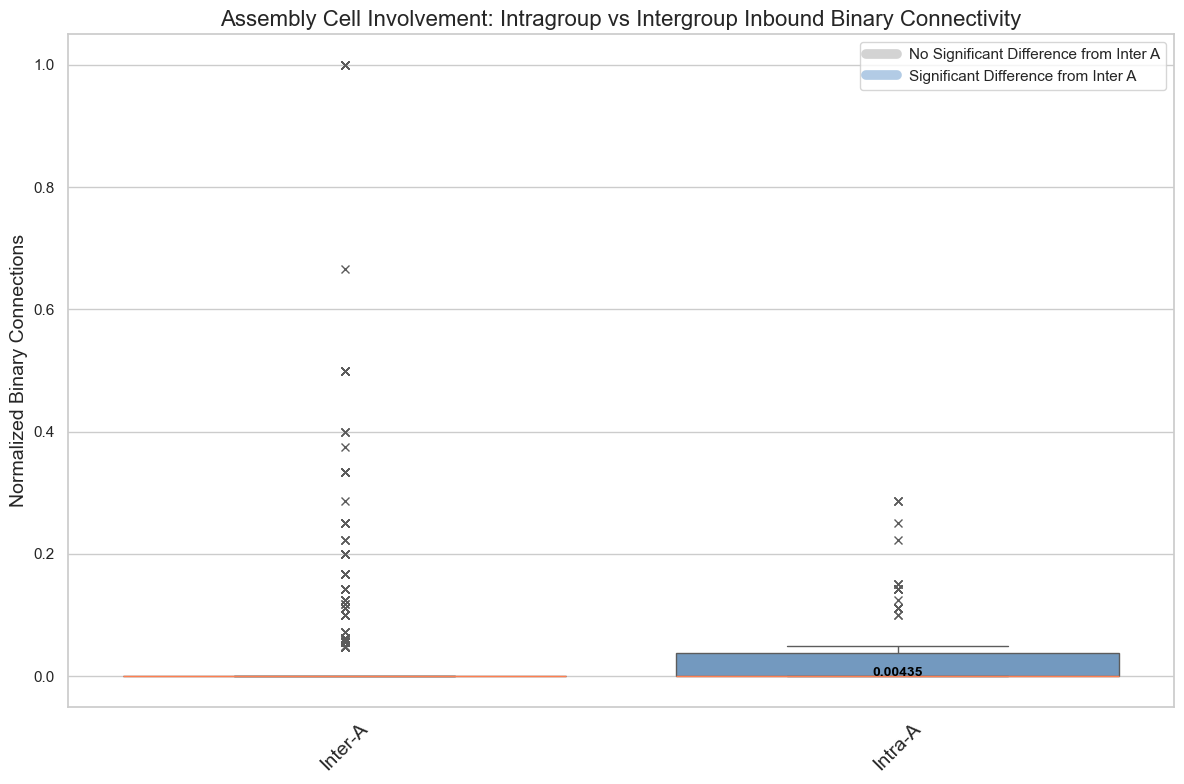

/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_56595/299252119.py:72: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, size = 14)


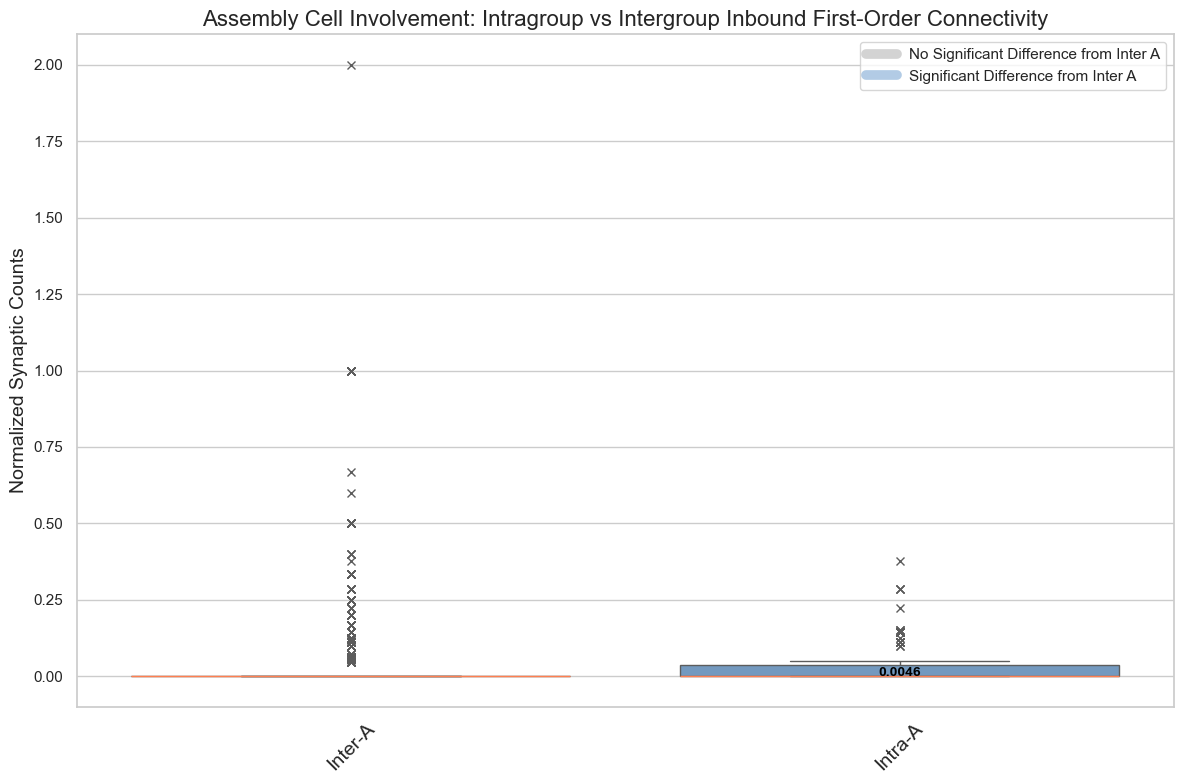

/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_56595/299252119.py:72: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, size = 14)


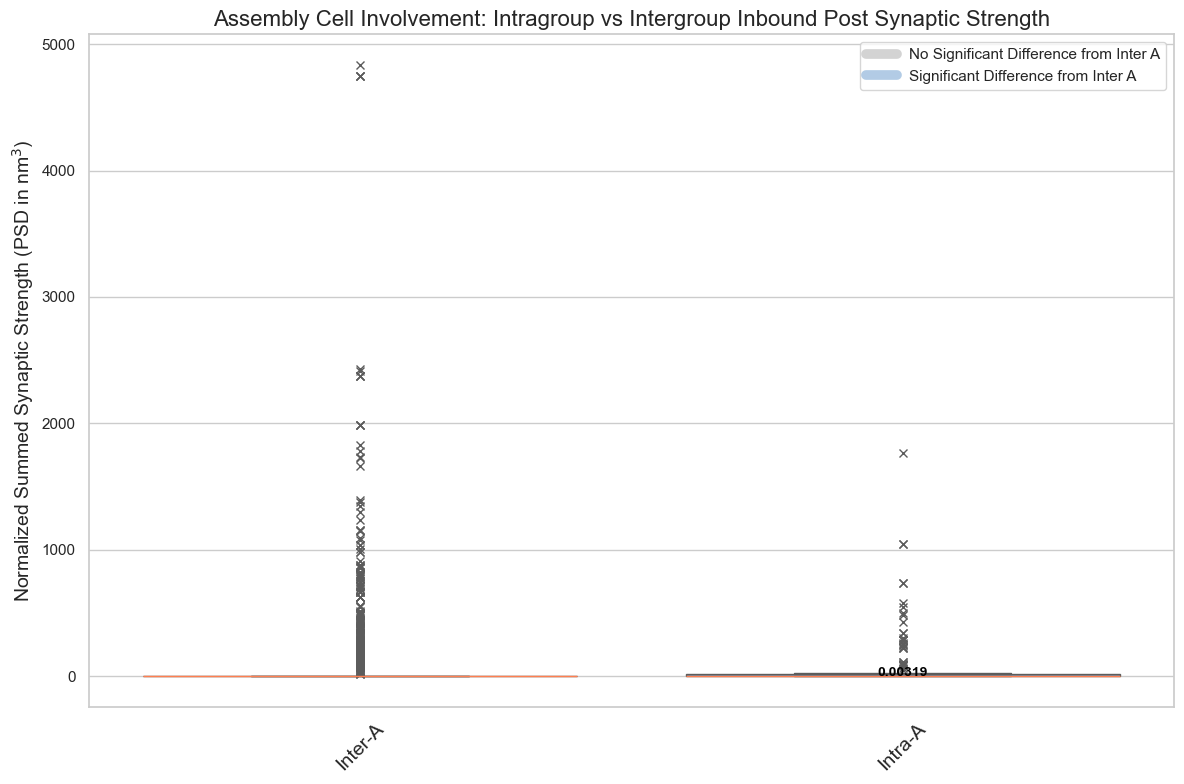

/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_56595/299252119.py:72: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, size = 14)


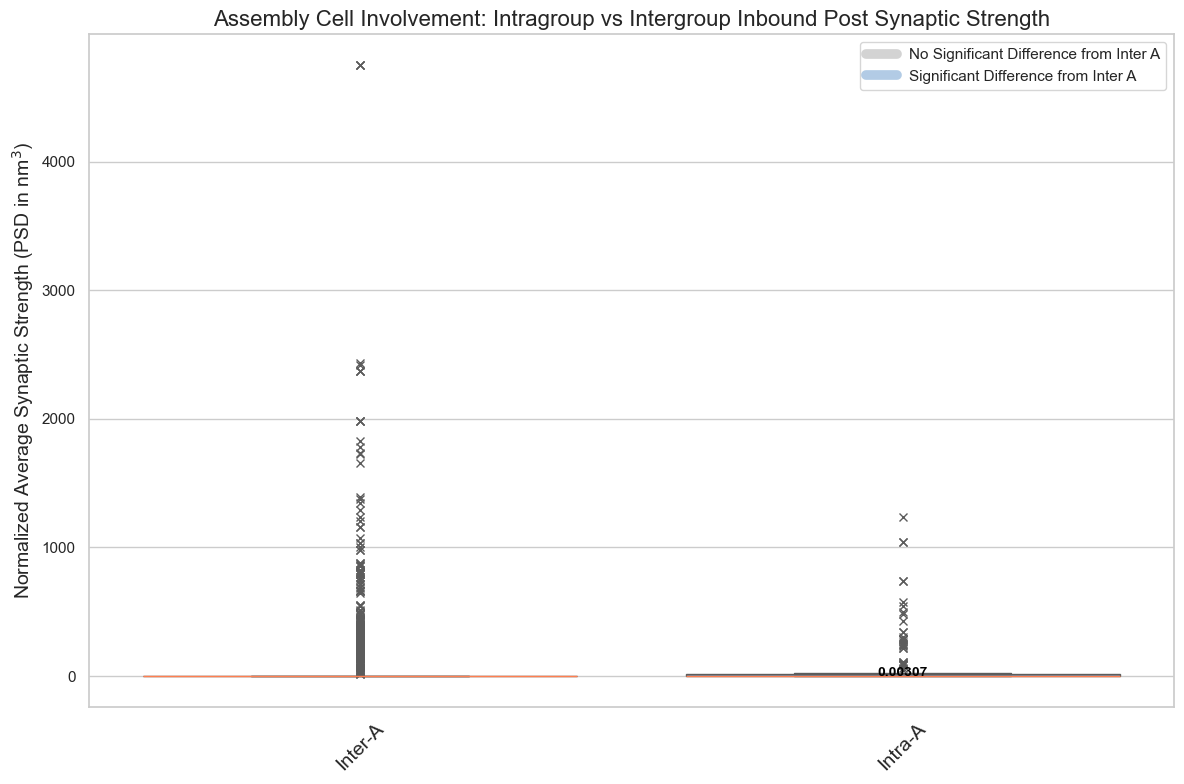

In [ ]:
inter_vs_intra_connections_plot(input_connections_dict = inbound_binary_intra_vs_inter_first_order_connections,
                                     directionality = 'Inbound', 
                                     binary_counts = True,
                                     syn_counts = False, 
                                     summed_psd = False,
                                     average_psd = False, 
                                     show_p_vals = True)
inter_vs_intra_connections_plot(input_connections_dict = inbound_syn_count_intra_vs_inter_first_order_connections,
                                     directionality = 'Inbound', 
                                     binary_counts = False,
                                     syn_counts = True, 
                                     summed_psd = False,
                                     average_psd = False, 
                                     show_p_vals = True)
inter_vs_intra_connections_plot(input_connections_dict = inbound_summed_psd_intra_vs_inter_first_order_connections,
                                     directionality = 'Inbound', 
                                     binary_counts = False,
                                     syn_counts = False, 
                                     summed_psd = True,
                                     average_psd = False, 
                                     show_p_vals = True)
inter_vs_intra_connections_plot(input_connections_dict = inbound_average_psd_intra_vs_inter_first_order_connections,
                                     directionality = 'Inbound', 
                                     binary_counts = False,
                                     syn_counts = False, 
                                     summed_psd = False,
                                     average_psd = True, 
                                     show_p_vals = True)

/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_56595/299252119.py:72: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, size = 14)


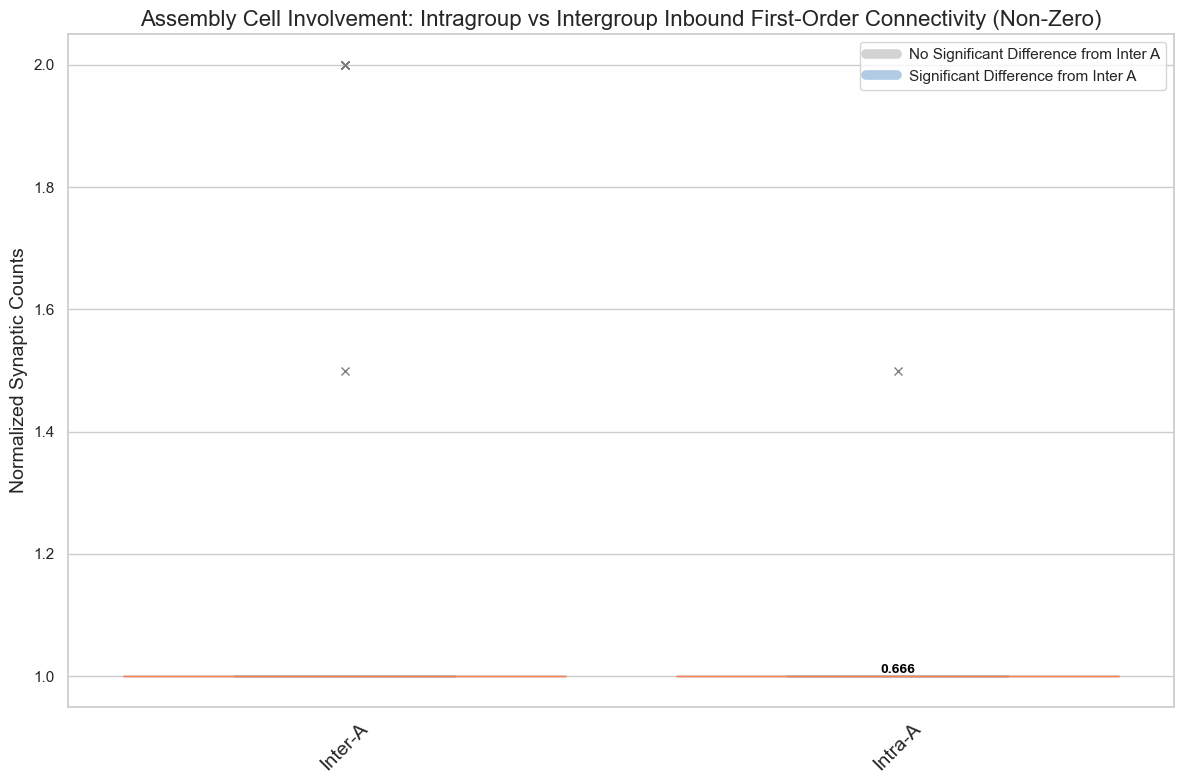

/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_56595/299252119.py:72: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, size = 14)


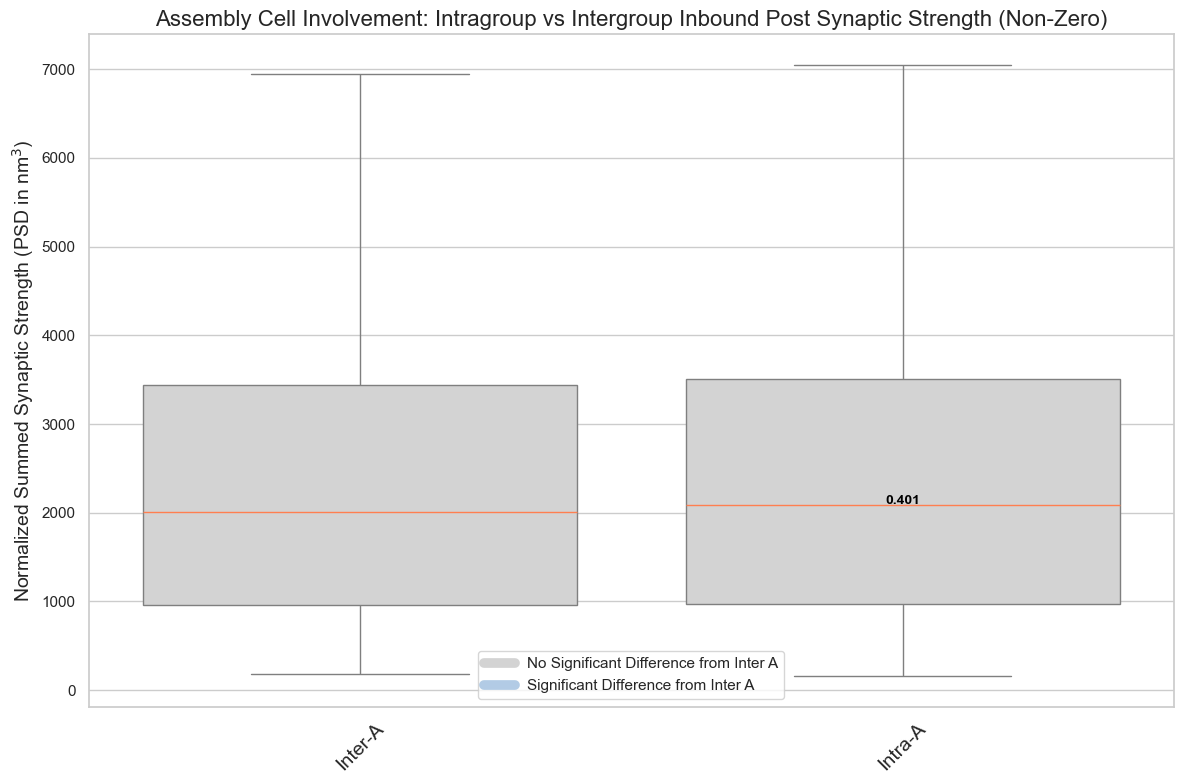

/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_56595/299252119.py:72: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, size = 14)


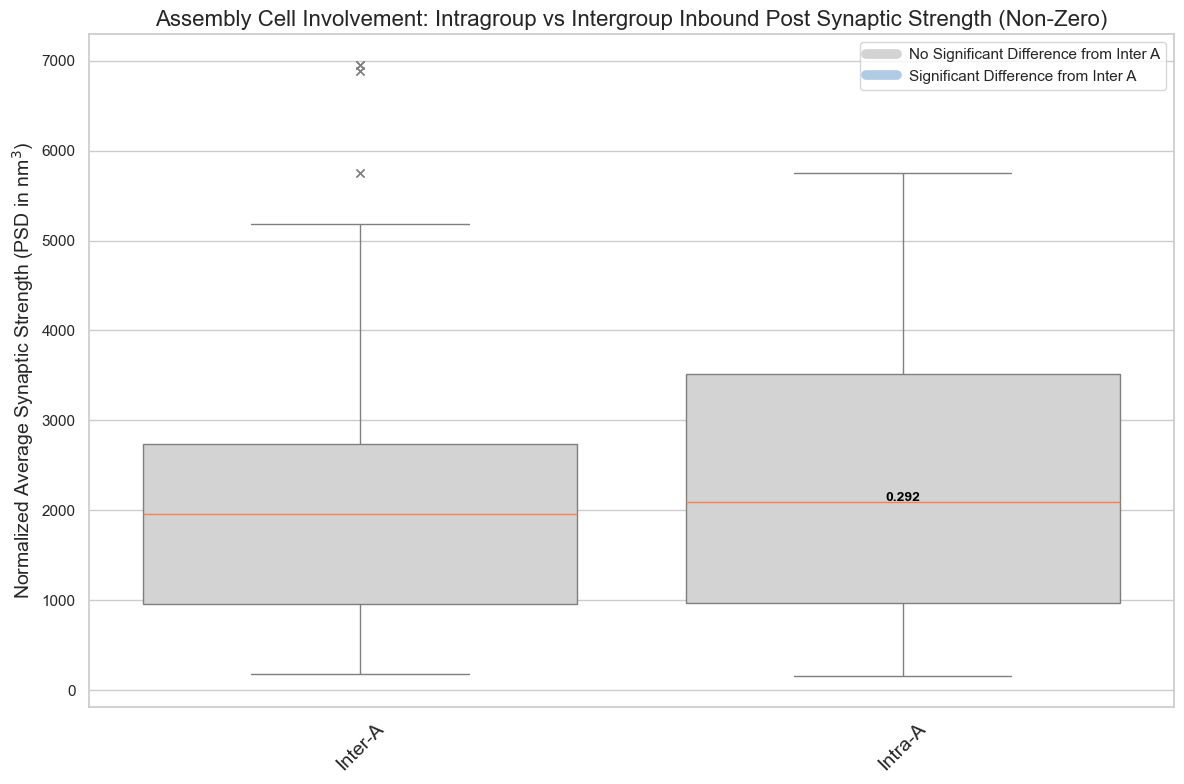

In [ ]:
inter_vs_intra_connections_plot(input_connections_dict = non_zero_inbound_syn_count_intra_vs_inter_first_order_connections,
                                     directionality = 'Inbound', 
                                     binary_counts = False,
                                     syn_counts = True, 
                                     summed_psd = False,
                                     average_psd = False, 
                                     show_p_vals = True,
                                     consider_zero_connections = False)
inter_vs_intra_connections_plot(input_connections_dict = non_zero_inbound_summed_psd_intra_vs_inter_first_order_connections,
                                     directionality = 'Inbound', 
                                     binary_counts = False,
                                     syn_counts = False, 
                                     summed_psd = True,
                                     average_psd = False, 
                                     show_p_vals = True,
                                     consider_zero_connections = False)
inter_vs_intra_connections_plot(input_connections_dict = non_zero_inbound_average_psd_intra_vs_inter_first_order_connections,
                                     directionality = 'Inbound', 
                                     binary_counts = False,
                                     syn_counts = False, 
                                     summed_psd = False,
                                     average_psd = True, 
                                     show_p_vals = True,
                                     consider_zero_connections = False)